In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (fbeta_score, f1_score, precision_score, recall_score,classification_report,ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, make_scorer, accuracy_score)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

from collections import Counter


In [3]:
##Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Change the current working directory
os.chdir('/content/gdrive/My Drive/CreditCardDefault')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/gdrive/My Drive/CreditCardDefault


In [5]:
############################## import train and Validate datasets #############################

df=pd.read_csv('/content/gdrive/My Drive/CreditCardDefault/train_dataset_final1.csv')
df_validate=pd.read_csv('/content/gdrive/My Drive/CreditCardDefault/validate_dataset_final.csv')
df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


# EDA

In [6]:
df.shape

(25247, 27)

In [7]:
#Statistics Summary
print("Statistics Summary:")
df.drop('Customer_ID', axis=1, inplace=True)
df.describe()

Statistics Summary:


,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
count,25247.000000,25247.000000,25247.000000,25247.000000,25121.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,...,25247.000000,25247.000000,2.524700e+04,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000,25247.000000
mean,1.551907,0.604111,1.852101,168342.060443,35.438199,-0.042857,-0.159544,-0.190359,-0.241415,-0.282568,...,38806.221029,5718.624966,6.047352e+03,5288.910651,4865.960834,4906.766828,5270.499287,44859.647485,0.362962,0.190399
std,0.522629,0.489050,0.797379,129892.784807,9.174998,1.099315,1.173990,1.172636,1.146753,1.114213,...,59182.792531,16806.842125,2.400962e+04,17851.879609,15979.116544,15860.726852,17960.816915,62819.226119,5.047206,0.392624
min,0.000000,0.000000,0.000000,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-56043.170000,-546.930000,0.000000
25%,1.000000,0.000000,1.000000,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1241.710000,999.985000,9.219100e+02,399.990000,300.150000,262.365000,130.070000,4858.670000,0.040000,0.000000
50%,2.000000,1.000000,2.000000,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,17102.580000,2145.020000,2.026830e+03,1844.300000,1500.100000,1513.790000,1500.040000,21102.830000,0.090000,0.000000
75%,2.000000,1.000000,2.000000,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,49245.195000,5031.150000,5.000190e+03,4600.640000,4014.990000,4099.890000,4018.780000,57136.580000,0.590000,0.000000
max,3.000000,1.000000,6.000000,1000000.000000,79.000000,8.000000,8.000000,8.000000,7.000000,7.000000,...,961663.620000,873551.980000,1.684259e+06,896040.150000,621000.080000,426529.180000,528666.150000,877313.830000,205.380000,1.000000


In [8]:
df.isnull().sum()

,0
marriage,0
sex,0
education,0
LIMIT_BAL,0
age,126
pay_0,0
pay_2,0
pay_3,0
pay_4,0
pay_5,0


In [9]:
df.columns.tolist()

['marriage',
 'sex',
 'education',
 'LIMIT_BAL',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'Bill_amt1',
 'Bill_amt2',
 'Bill_amt3',
 'Bill_amt4',
 'Bill_amt5',
 'Bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'AVG_Bill_amt',
 'PAY_TO_BILL_ratio',
 'next_month_default']

In [10]:
df.nunique()

,0
marriage,4
sex,2
education,7
LIMIT_BAL,80
age,56
pay_0,11
pay_2,11
pay_3,11
pay_4,10
pay_5,9


Text(0.5, 1.0, 'Percentage of Default and Non-Default Payment')

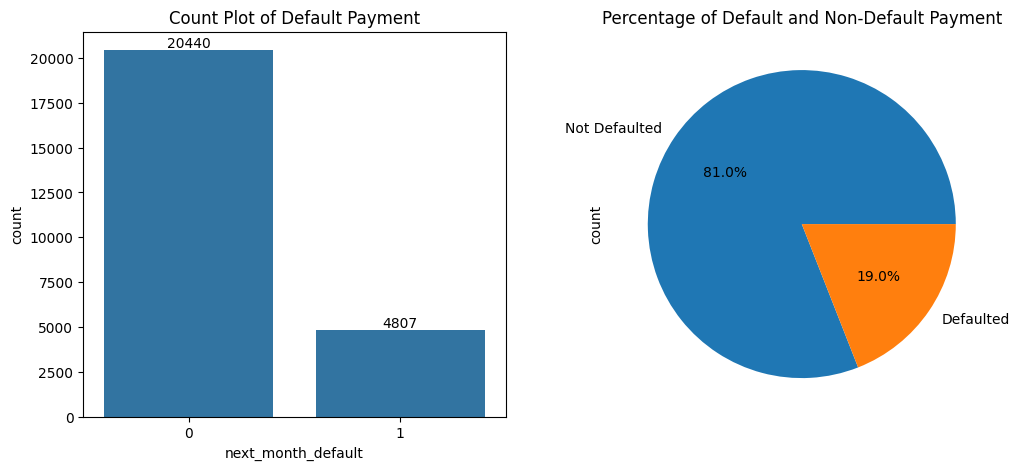

In [11]:
##################################### Univariate analysis ###################################
################ Analysis of Default next month

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Count Plot of Default Payment
count = sns.countplot(data=df, x='next_month_default', ax=ax[0])
count.set_title('Count Plot of Default Payment')

# Add count labels at center of bars
for p in count.patches:
    count.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom'
    )

# Pie chart of Default and Non-Default Payment
pie = df['next_month_default'].value_counts().plot(
    kind='pie',
    autopct="%1.1f%%",
    labels=['Not Defaulted', 'Defaulted'],
    ax=ax[1]
)
pie.set_title('Percentage of Default and Non-Default Payment')


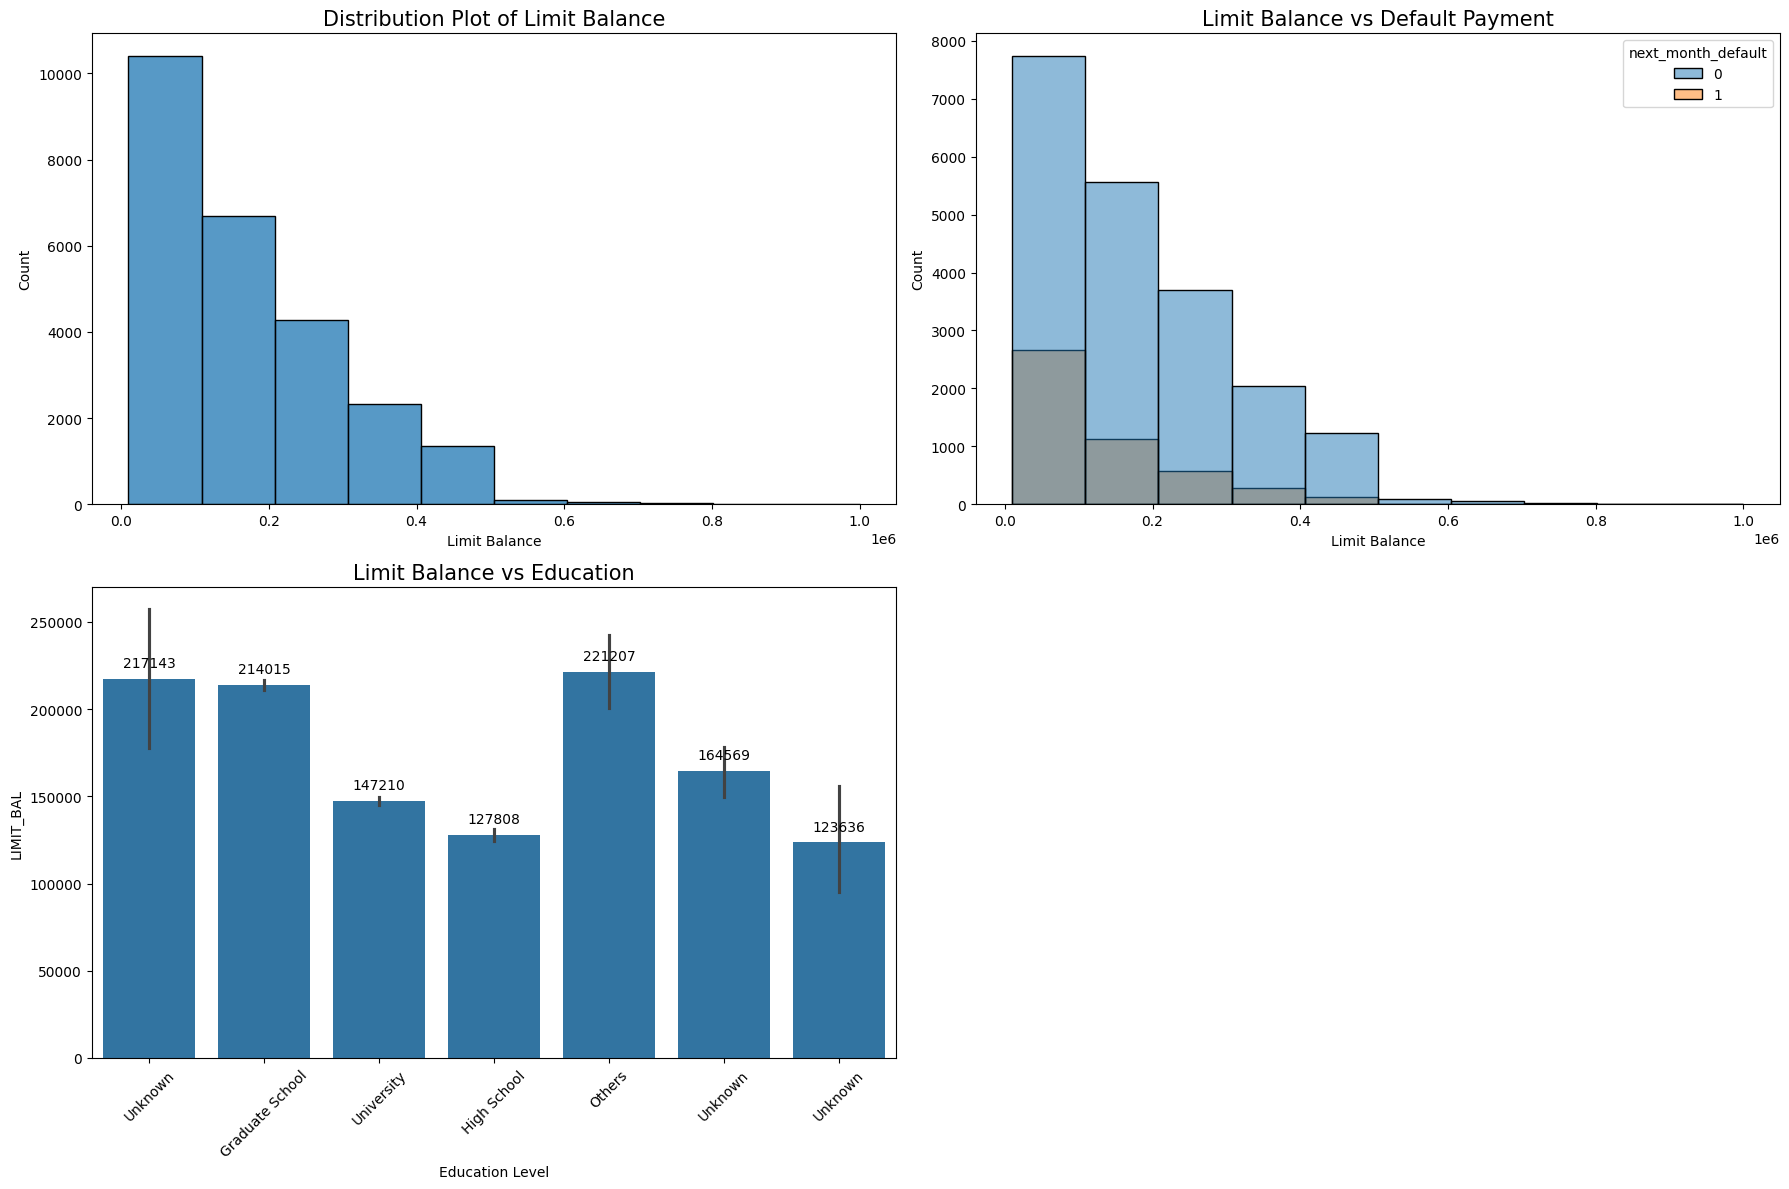

In [12]:
############### Analysis of Limit_Bal
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# 1. Univariate Analysis: Distribution of Limit Balance
sns.histplot(df['LIMIT_BAL'], bins=10, ax=ax[0][0])
ax[0][0].set_title('Distribution Plot of Limit Balance', size=15)
ax[0][0].set_xlabel('Limit Balance')

# 2. Bivariate Analysis: Limit Balance vs Default Payment
sns.histplot(data=df, x='LIMIT_BAL', hue='next_month_default', bins=10, ax=ax[0][1])
ax[0][1].set_title('Limit Balance vs Default Payment', size=15)
ax[0][1].set_xlabel('Limit Balance')

# 3. Bivariate Analysis: Limit Balance vs EDUCATION
sns.barplot(data=df, x='education', y='LIMIT_BAL', ax=ax[1][0])
ax[1][0].set_title('Limit Balance vs Education', size=15)
ax[1][0].set_xlabel('Education Level')

# Set custom x-tick labels for Education
ax[1][0].set_xticks(range(7))
ax[1][0].set_xticklabels(['Unknown', 'Graduate School', 'University', 'High School', 'Others', 'Unknown', 'Unknown'], rotation=45)

# Annotate bar values
for p in ax[1][0].patches:
    ax[1][0].annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2, p.get_height() + 5000),
        ha='center', va='bottom'
    )

# Hide the unused subplot
ax[1][1].axis('off')

plt.tight_layout()
plt.show()



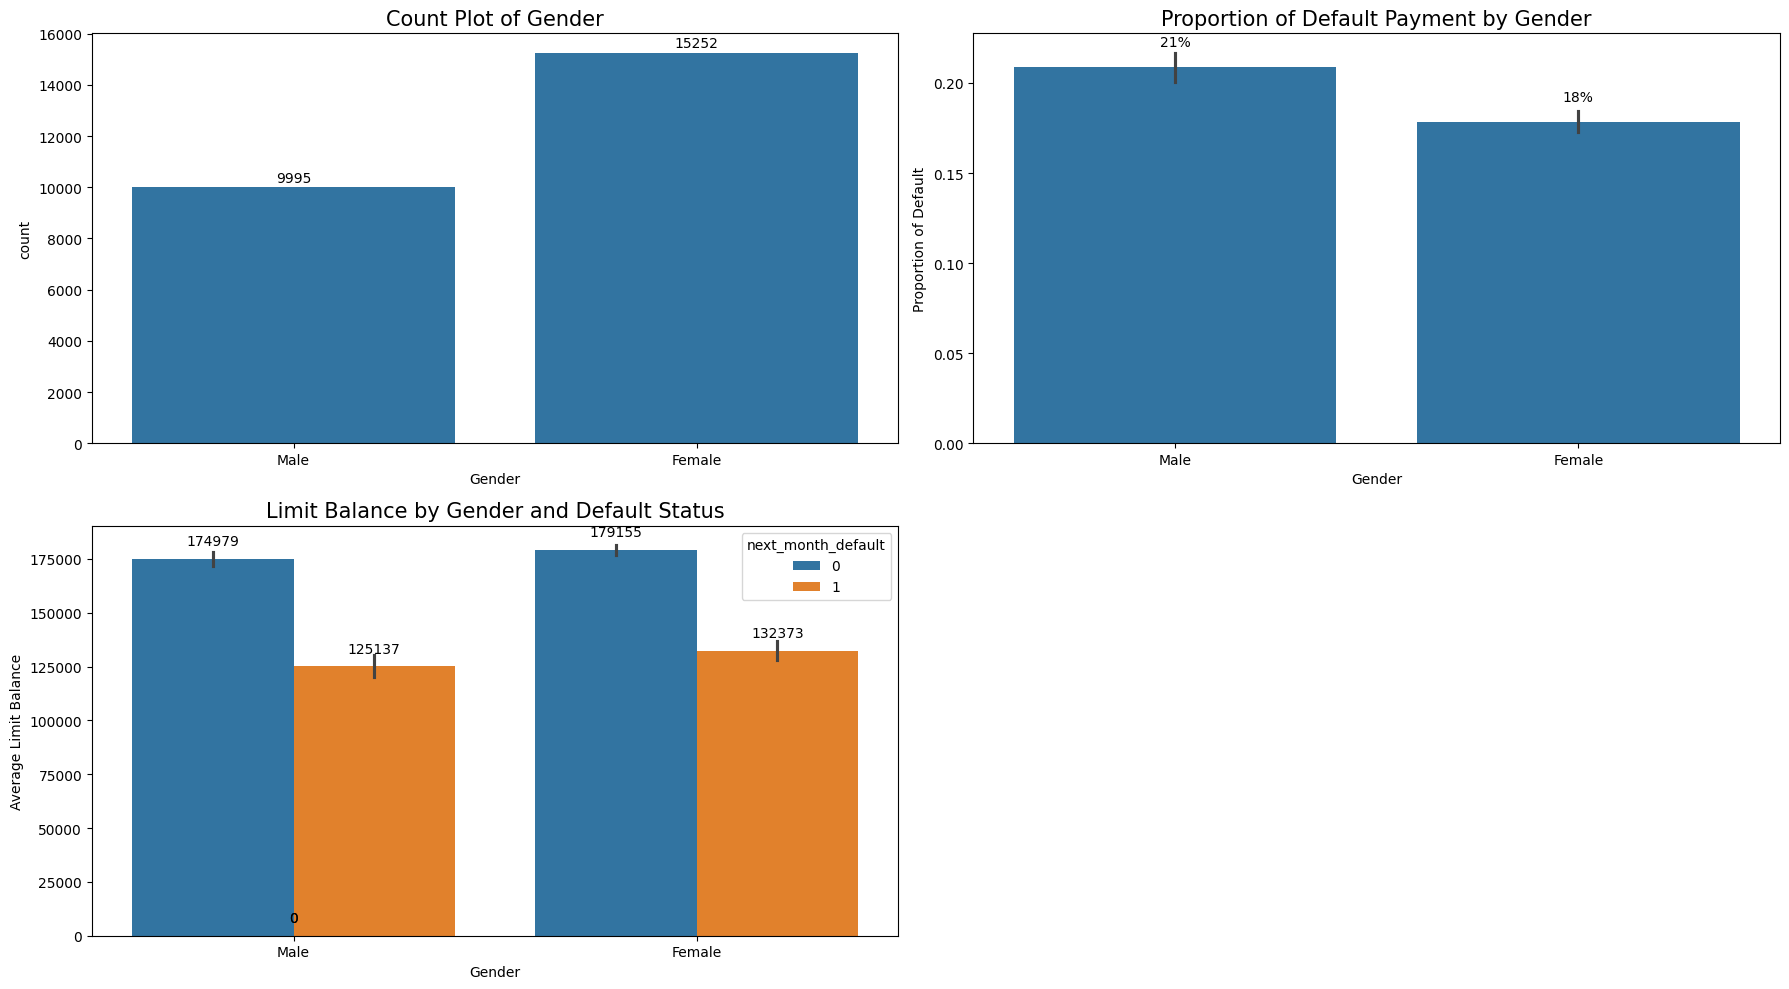

In [13]:
################# Analysis of Gender
fig, ax = plt.subplots(2, 2, figsize=(18,10))

# 1. Univariate Analysis: Count Plot of Gender
countplot_gender = sns.countplot(x='sex', data=df, ax=ax[0][0])
countplot_gender.set_title('Count Plot of Gender', size=15)
countplot_gender.set_xlabel('Gender')

# Set gender labels (1 = Male, 2 = Female)
countplot_gender.set_xticks([0, 1])
countplot_gender.set_xticklabels(['Male', 'Female'])

# Add count annotations (centered and slightly above)
for p in countplot_gender.patches:
    countplot_gender.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2, p.get_height() + 100),
        ha='center', va='bottom'
    )

# 2. Bivariate Analysis: Gender vs Default Proportion
barplot_default_rate = sns.barplot(data=df, x='sex', y='next_month_default', ax=ax[0][1])
barplot_default_rate.set_title('Proportion of Default Payment by Gender', size=15)
barplot_default_rate.set_xlabel('Gender')
barplot_default_rate.set_ylabel('Proportion of Default')

barplot_default_rate.set_xticks([0, 1])
barplot_default_rate.set_xticklabels(['Male', 'Female'])

# Add percentage annotations (as % and above)
for p in barplot_default_rate.patches:
    barplot_default_rate.annotate(
        f"{p.get_height() * 100:.0f}%",
        (p.get_x() + p.get_width() / 2, p.get_height() + 0.01),
        ha='center', va='bottom'
    )

# 3. Multivariate Analysis: Gender vs Default with Limit Balance
barplot_limit = sns.barplot(data=df, x='sex', y='LIMIT_BAL', hue='next_month_default', ax=ax[1][0])
barplot_limit.set_title('Limit Balance by Gender and Default Status', size=15)
barplot_limit.set_xlabel('Gender')
barplot_limit.set_ylabel('Average Limit Balance')

barplot_limit.set_xticks([0, 1])
barplot_limit.set_xticklabels(['Male', 'Female'])

# Add value annotations
for p in barplot_limit.patches:
    barplot_limit.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2, p.get_height() + 5000),
        ha='center', va='bottom'
    )

# 4. Remove empty subplot (bottom right)
fig.delaxes(ax[1][1])

plt.tight_layout()
plt.show()


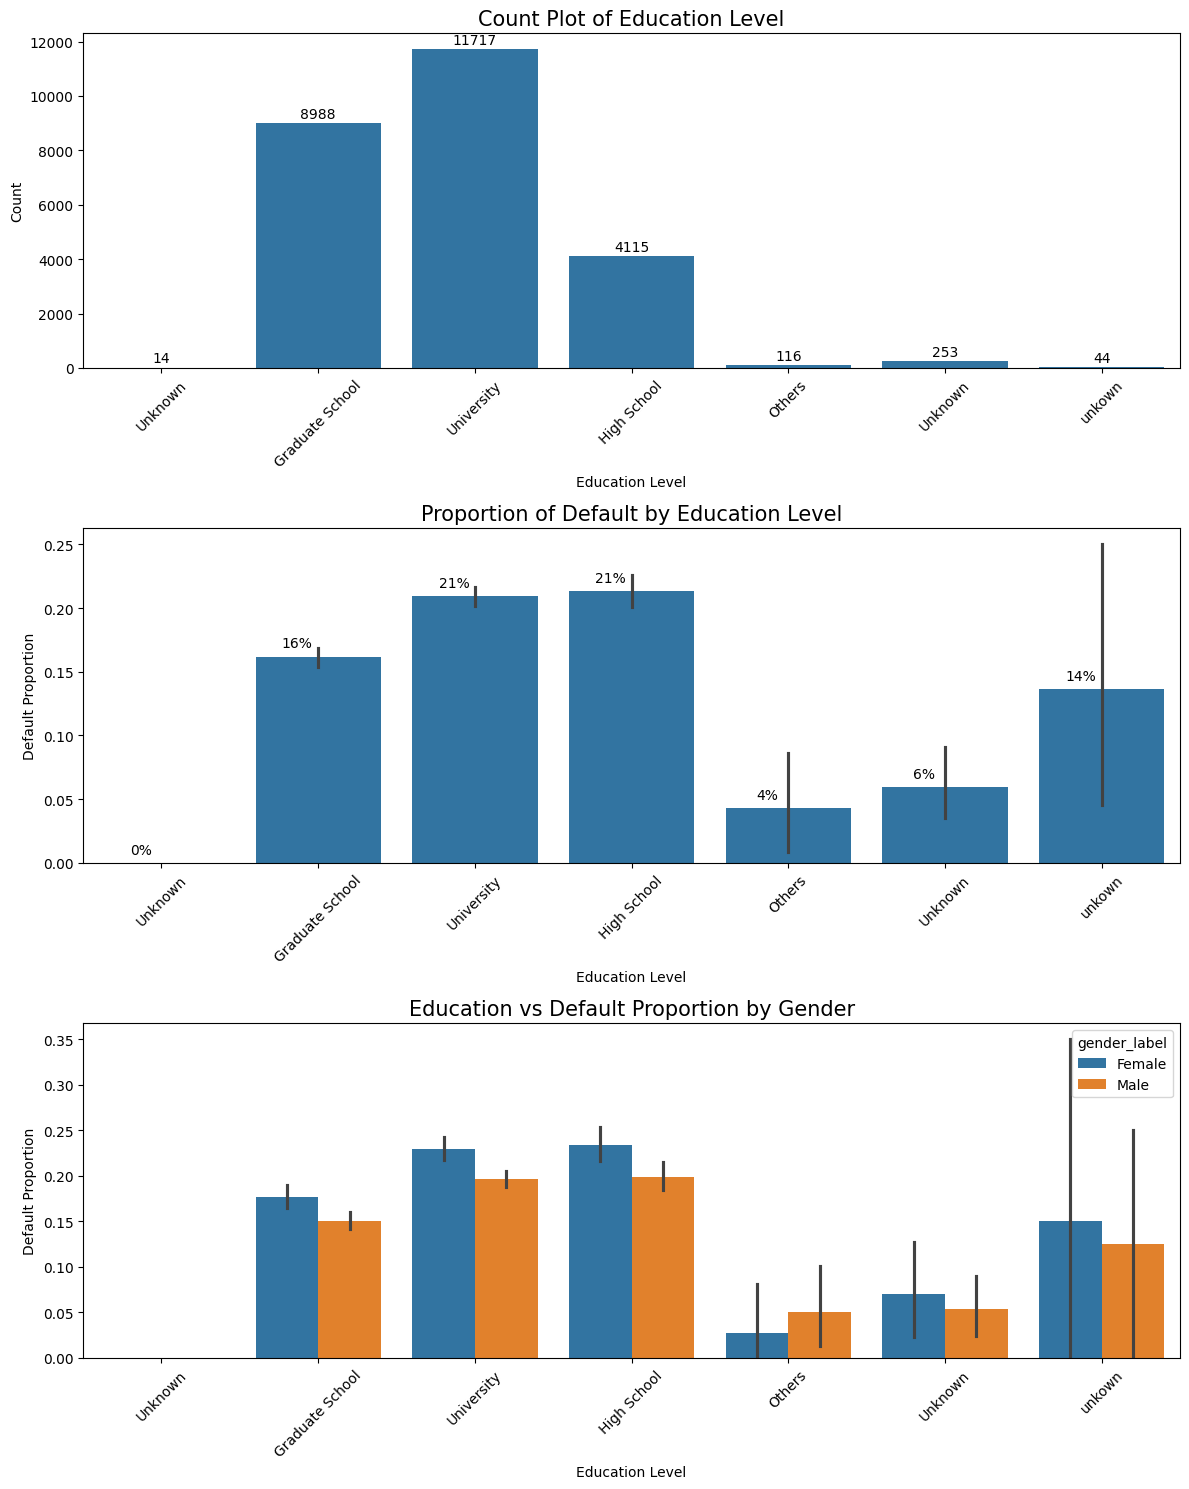

In [14]:
################# Analysis of Education

fig, ax = plt.subplots(3, 1, figsize=(12, 15))

# 1. Univariate Analysis: Count of Education Levels
countplot = sns.countplot(x='education', data=df, ax=ax[0])
countplot.set_title('Count Plot of Education Level', fontsize=15)
countplot.set_xlabel('Education Level')
countplot.set_ylabel('Count')

# Set x-tick labels corresponding to actual codes
countplot.set_xticks(range(7))
countplot.set_xticklabels(['Unknown', 'Graduate School', 'University', 'High School', 'Others', 'Unknown','unkown'], rotation=45)

# Add value annotations (centered & a bit above the bars)
for p in countplot.patches:
    countplot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2, p.get_height() + 80),
        ha='center', va='bottom'
    )

# 2. Bivariate Analysis: Education vs Default Proportion
barplot = sns.barplot(data=df, x='education', y='next_month_default', ax=ax[1])
barplot.set_title('Proportion of Default by Education Level', fontsize=15)
barplot.set_xlabel('Education Level')
barplot.set_ylabel('Default Proportion')

barplot.set_xticks(range(7))
barplot.set_xticklabels(['Unknown', 'Graduate School', 'University', 'High School', 'Others', 'Unknown','unkown'], rotation=45)

# Add proportion annotations (centered & above)
for p in barplot.patches:
    barplot.annotate(
        f"{p.get_height() * 100:.0f}%",
        (p.get_x() + p.get_width() / 3, p.get_height() + 0.005),
        ha='center', va='bottom'
    )

# 3. Multivariate Analysis: Education vs Default Proportion split by Gender
df['gender_label'] = df['sex'].map({0: 'Female', 1: 'Male'})

barplot = sns.barplot(data=df, x='education', y='next_month_default', hue='gender_label', ax=ax[2])
barplot.set_title('Education vs Default Proportion by Gender', fontsize=15)
barplot.set_xlabel('Education Level')
barplot.set_ylabel('Default Proportion')

barplot.set_xticks(range(7))
barplot.set_xticklabels(['Unknown', 'Graduate School', 'University', 'High School', 'Others', 'Unknown','unkown'], rotation=45)

plt.tight_layout()
plt.show()


df.drop('gender_label',axis=1, inplace= True)



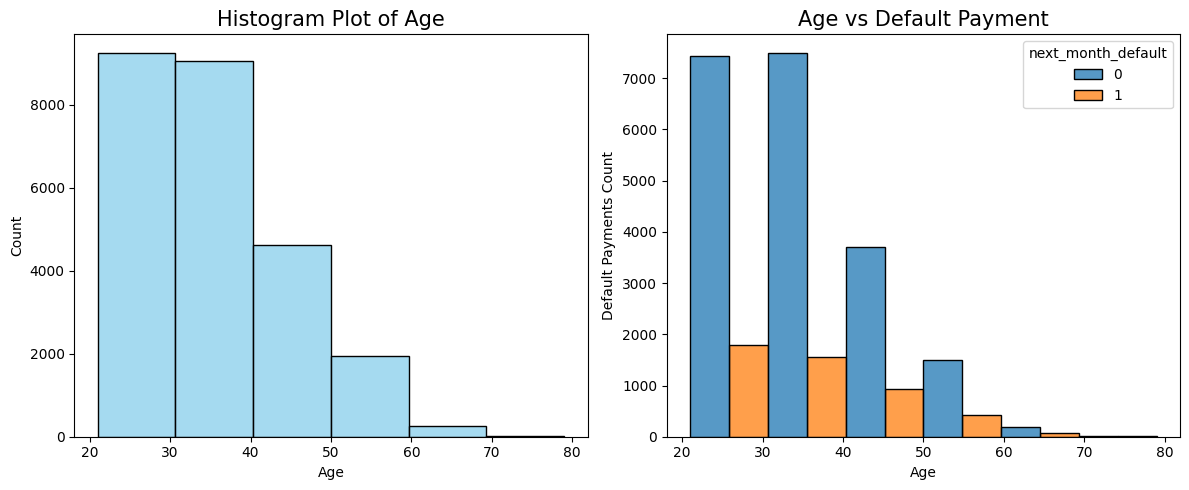

In [15]:
############# Analysis of Age

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Univariate analysis: Age distribution
histplot = sns.histplot(df['age'], bins=6, ax=ax[0], color='skyblue', edgecolor='black')
histplot.set_title('Histogram Plot of Age', size=15)
histplot.set_xlabel('Age')
histplot.set_ylabel('Count')

# 2. Bivariate analysis: Age vs Default Payment
histplot = sns.histplot(
    data=df,
    x='age',
    hue='next_month_default',
    bins=6,
    ax=ax[1],
    multiple='dodge',
    edgecolor='black'
)
histplot.set_title('Age vs Default Payment', size=15)
histplot.set_xlabel('Age')
histplot.set_ylabel('Default Payments Count')

plt.tight_layout()
plt.show()


<Axes: xlabel='pay_6', ylabel='count'>

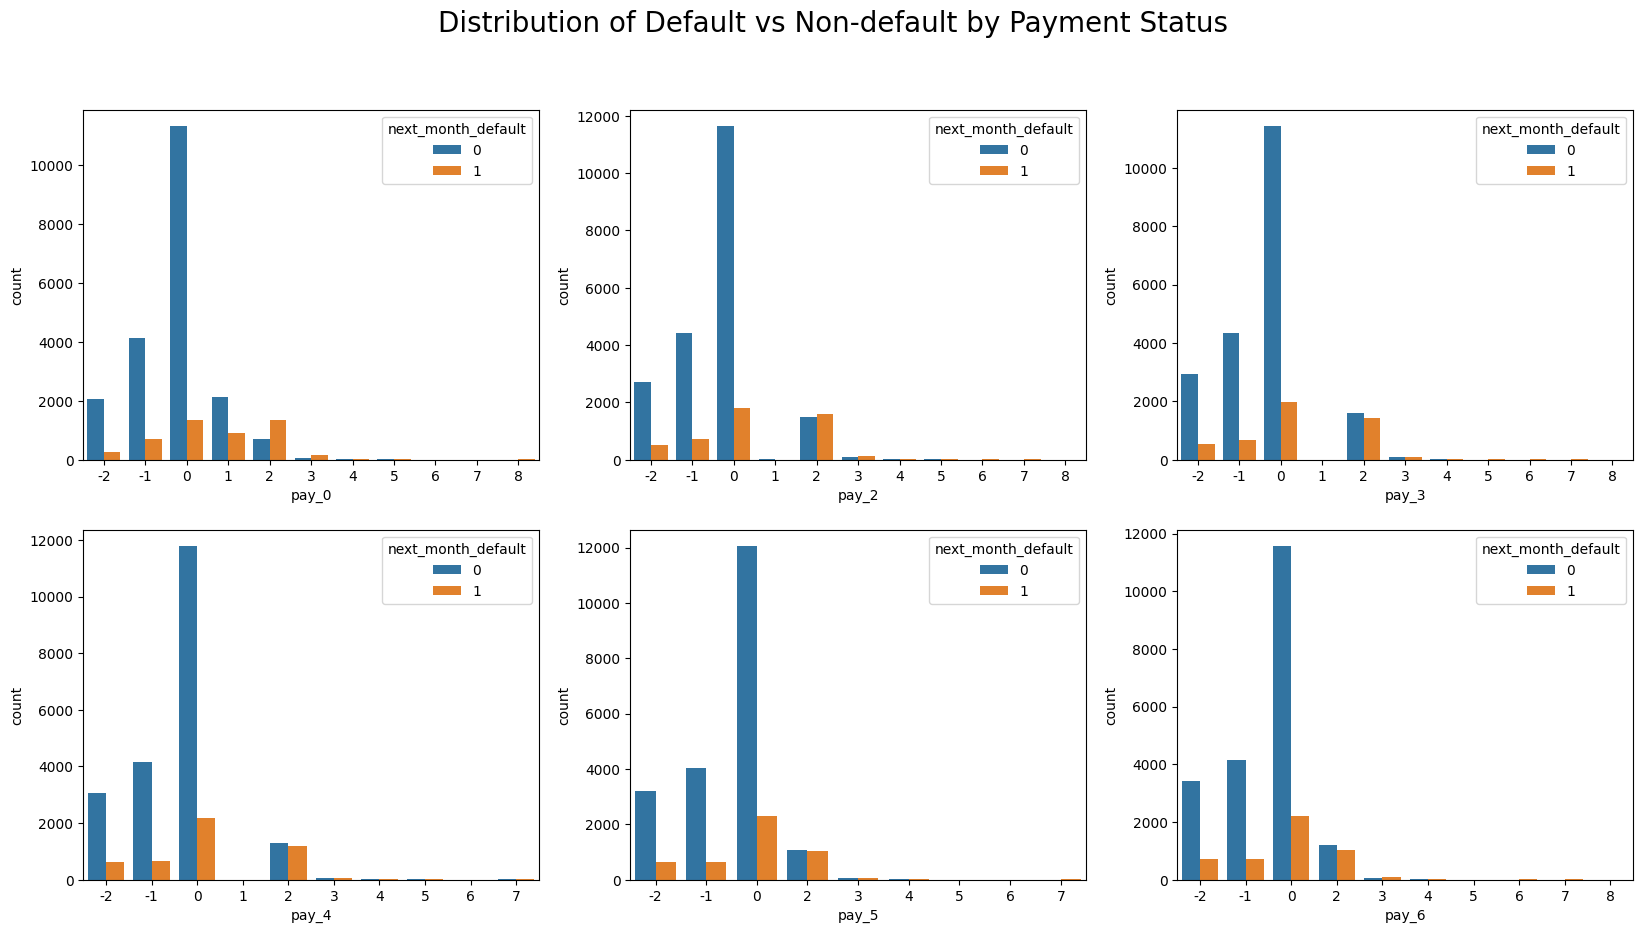

In [16]:
############### Analysis of Payment status
pay_hist = df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'next_month_default']]

f, axes = plt.subplots(2, 3, figsize=(20, 10), facecolor='white')
f.suptitle('Distribution of Default vs Non-default by Payment Status', size=20)
sns.countplot(x='pay_0', hue="next_month_default", data=pay_hist, ax=axes[0,0])
sns.countplot(x="pay_2", hue="next_month_default", data=pay_hist, ax=axes[0,1])
sns.countplot(x="pay_3", hue="next_month_default", data=pay_hist, ax=axes[0,2])
sns.countplot(x="pay_4", hue="next_month_default", data=pay_hist, ax=axes[1,0])
sns.countplot(x="pay_5", hue="next_month_default", data=pay_hist, ax=axes[1,1])
sns.countplot(x="pay_6", hue="next_month_default", data=pay_hist, ax=axes[1,2])

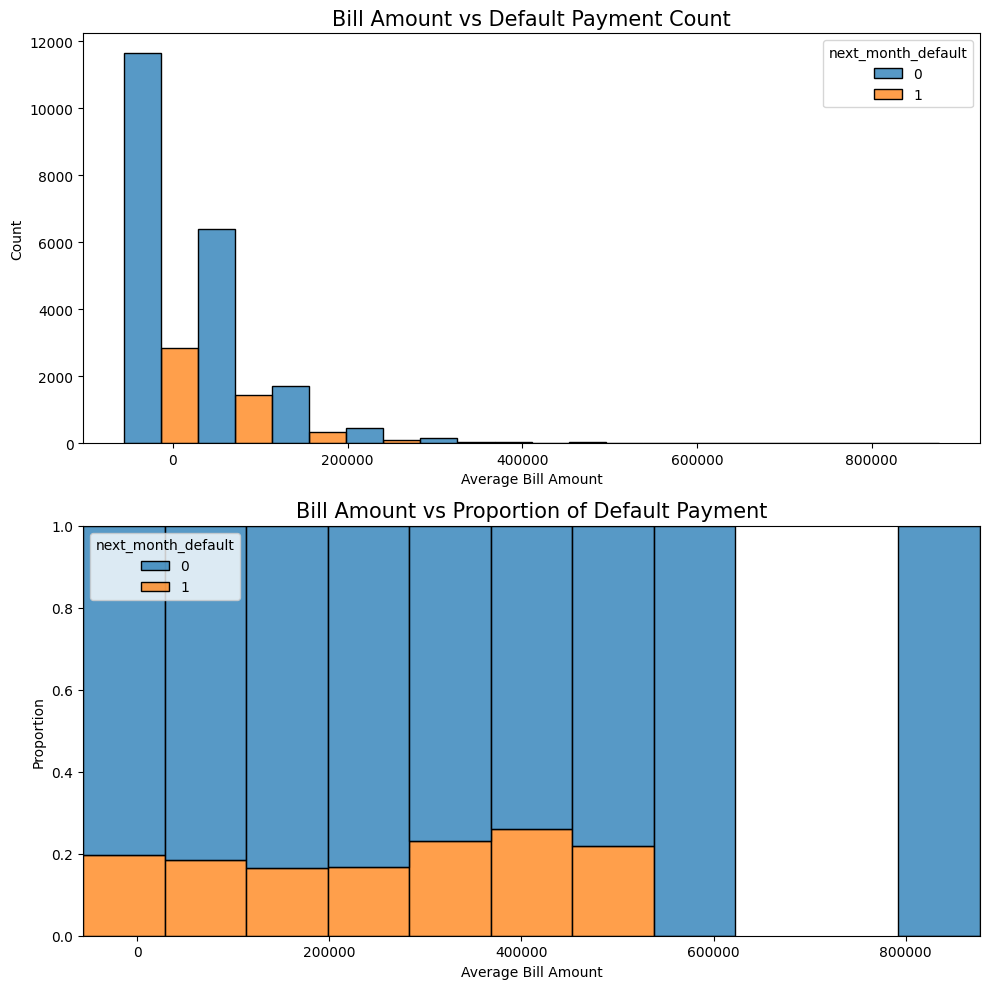

In [17]:
############## Analysis of Average bill Amount

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# 1. Bivariate analysis: Bill amount vs Default Payment Count
hist1 = sns.histplot(data=df,x='AVG_Bill_amt',hue='next_month_default',bins=11,multiple='dodge',edgecolor='black',ax=ax[0])
hist1.set_title('Bill Amount vs Default Payment Count', size=15)
hist1.set_xlabel('Average Bill Amount')
hist1.set_ylabel('Count')

# 2. Bivariate analysis: Bill amount vs Proportion of Default Payment
hist2 = sns.histplot(
    data=df,x='AVG_Bill_amt',hue='next_month_default',bins=11,multiple='fill',stat='probability',edgecolor='black',ax=ax[1])
hist2.set_title('Bill Amount vs Proportion of Default Payment', size=15)
hist2.set_xlabel('Average Bill Amount')
hist2.set_ylabel('Proportion')

plt.tight_layout()
plt.show()


In [18]:
########## Separate Numerical and Categorical variables
numerical_features = []
categorical_features = []

for col in df.columns:
  if df[col].nunique() > 15:
    numerical_features.append(col)
  else:
    categorical_features.append(col)


categorical_features.remove('next_month_default')

print(f'Numerical Features : {numerical_features}')
print(f'Categorical Features : {categorical_features}')




Numerical Features : ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
Categorical Features : ['marriage', 'sex', 'education', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


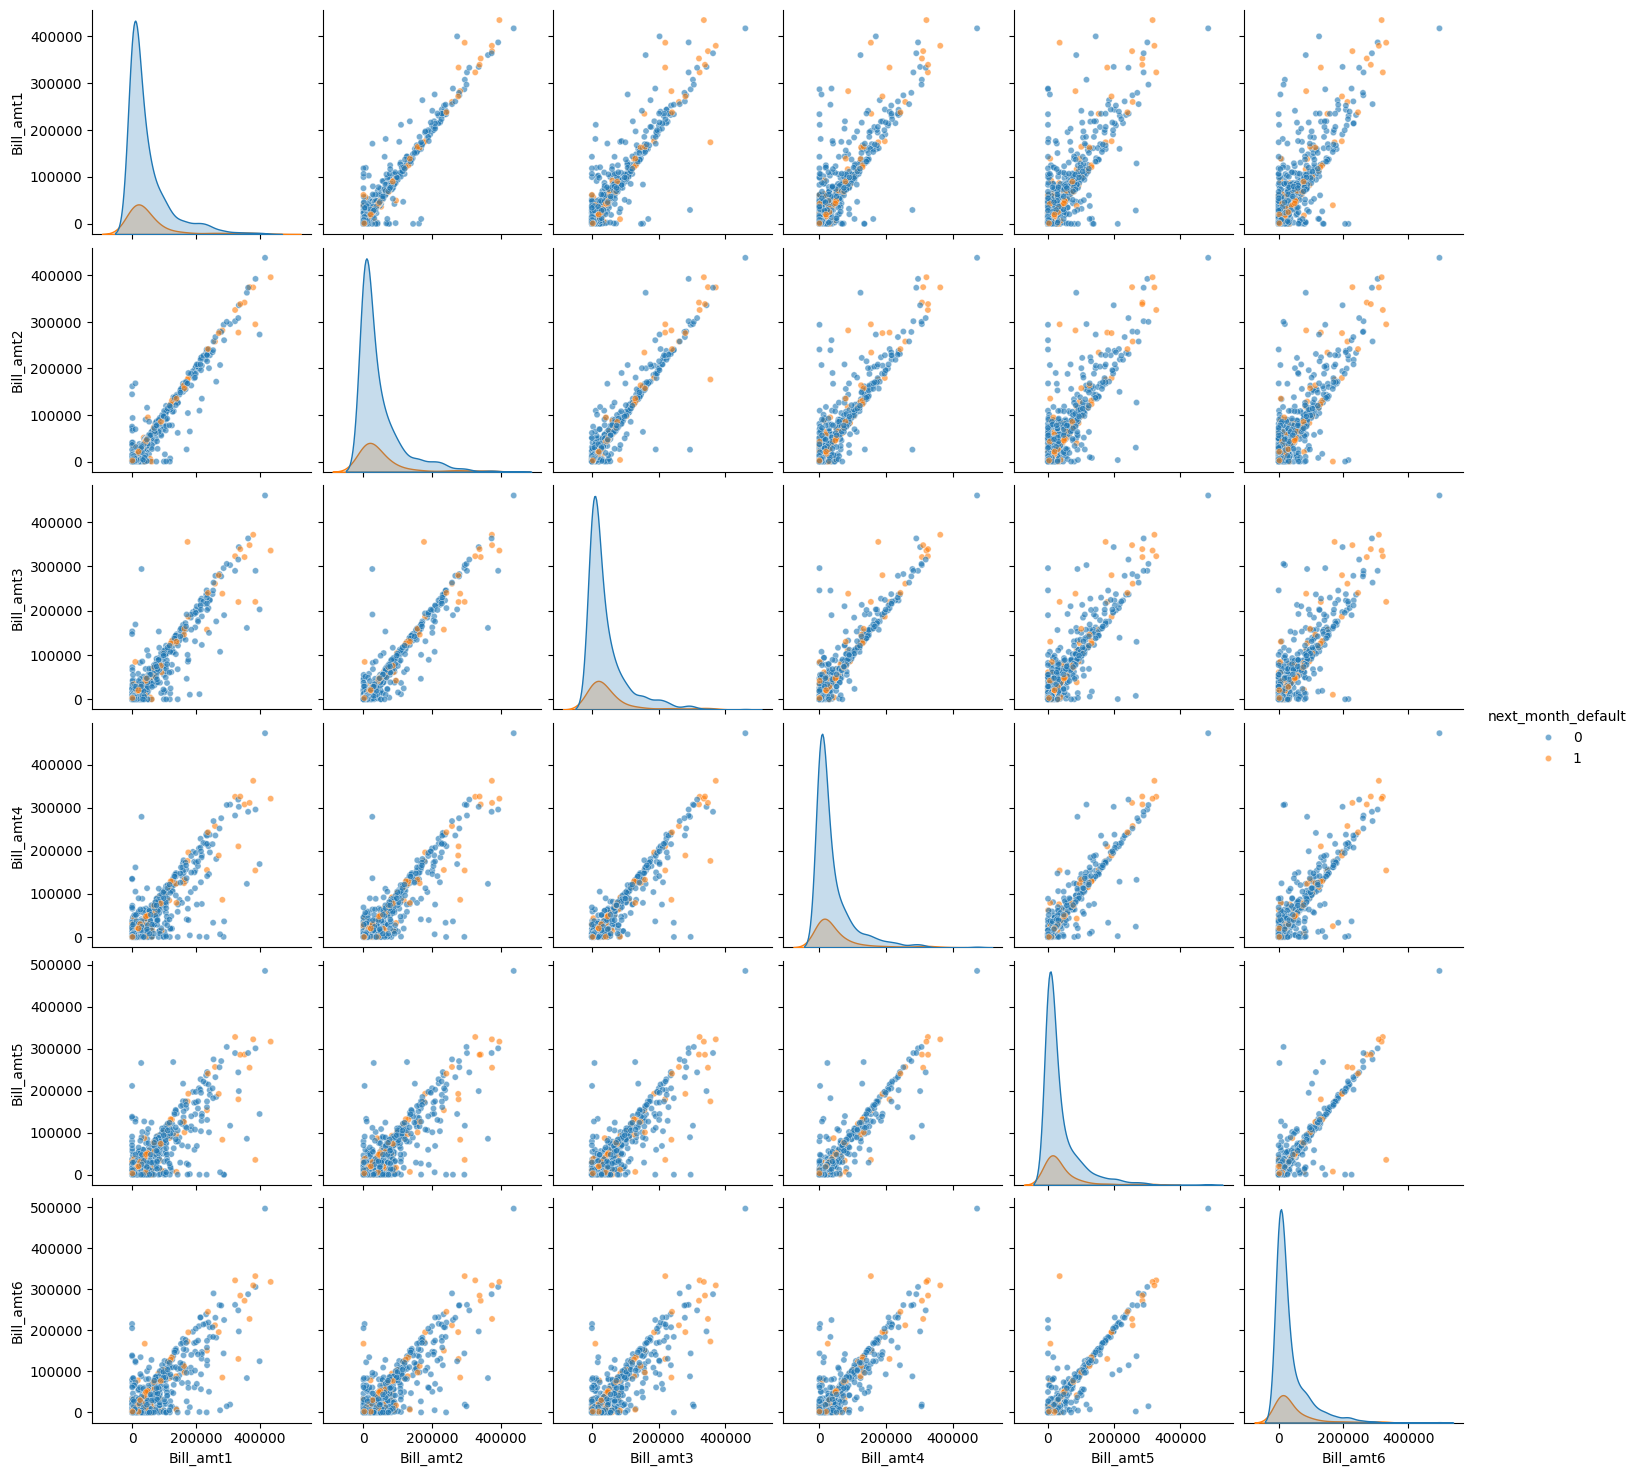

In [19]:
##################### Pairplots of bill amounts
sample_df = df.sample(n=1000, random_state=42)

sns.pairplot(data=sample_df,
    vars=sample_df.columns[11:17],
    hue='next_month_default',
    diag_kind='kde',
    plot_kws={'s': 20, 'alpha': 0.6}
)


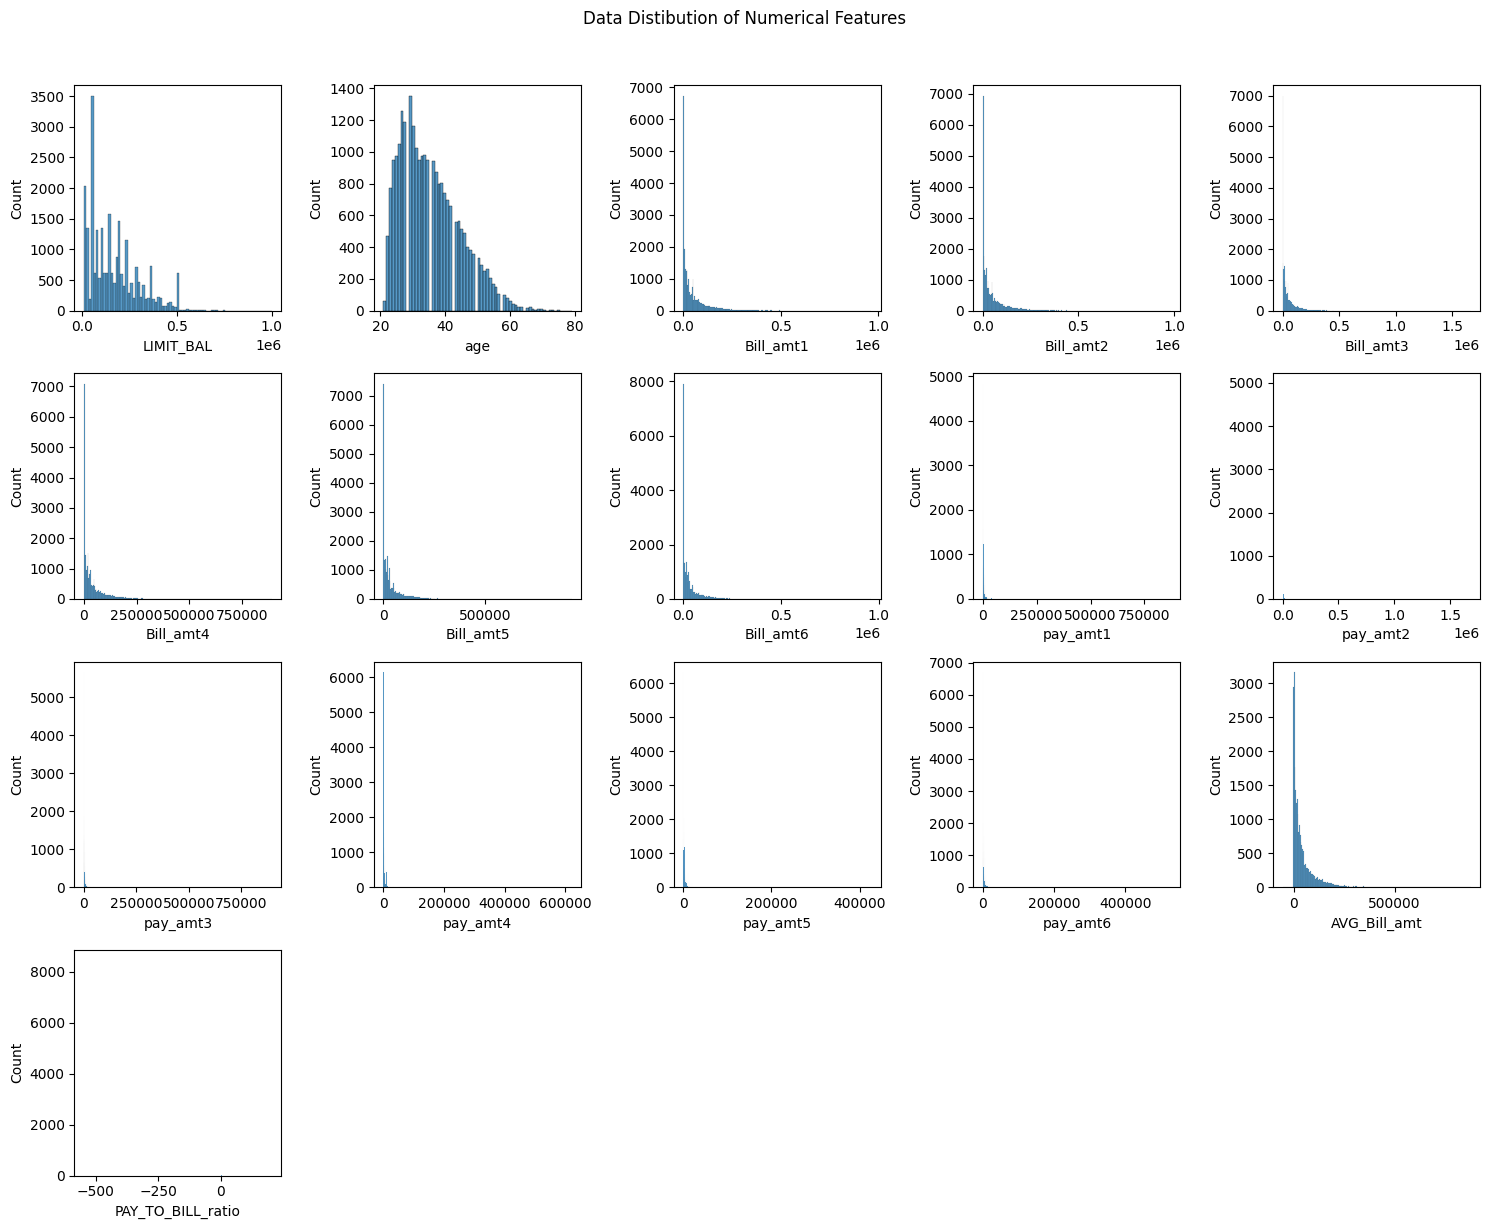

In [20]:
############################## Analysis of numerical variables
# figsize
plt.figure(figsize=(15,12))
# title
plt.suptitle('Data Distibution of Numerical Features',  y=1.02)

for i,col in enumerate(numerical_features):
  plt.subplot(4, 5, i+1)

  # dist plots
  sns.histplot(df[col])
  # x-axis label
  plt.xlabel(col)
  plt.tight_layout()

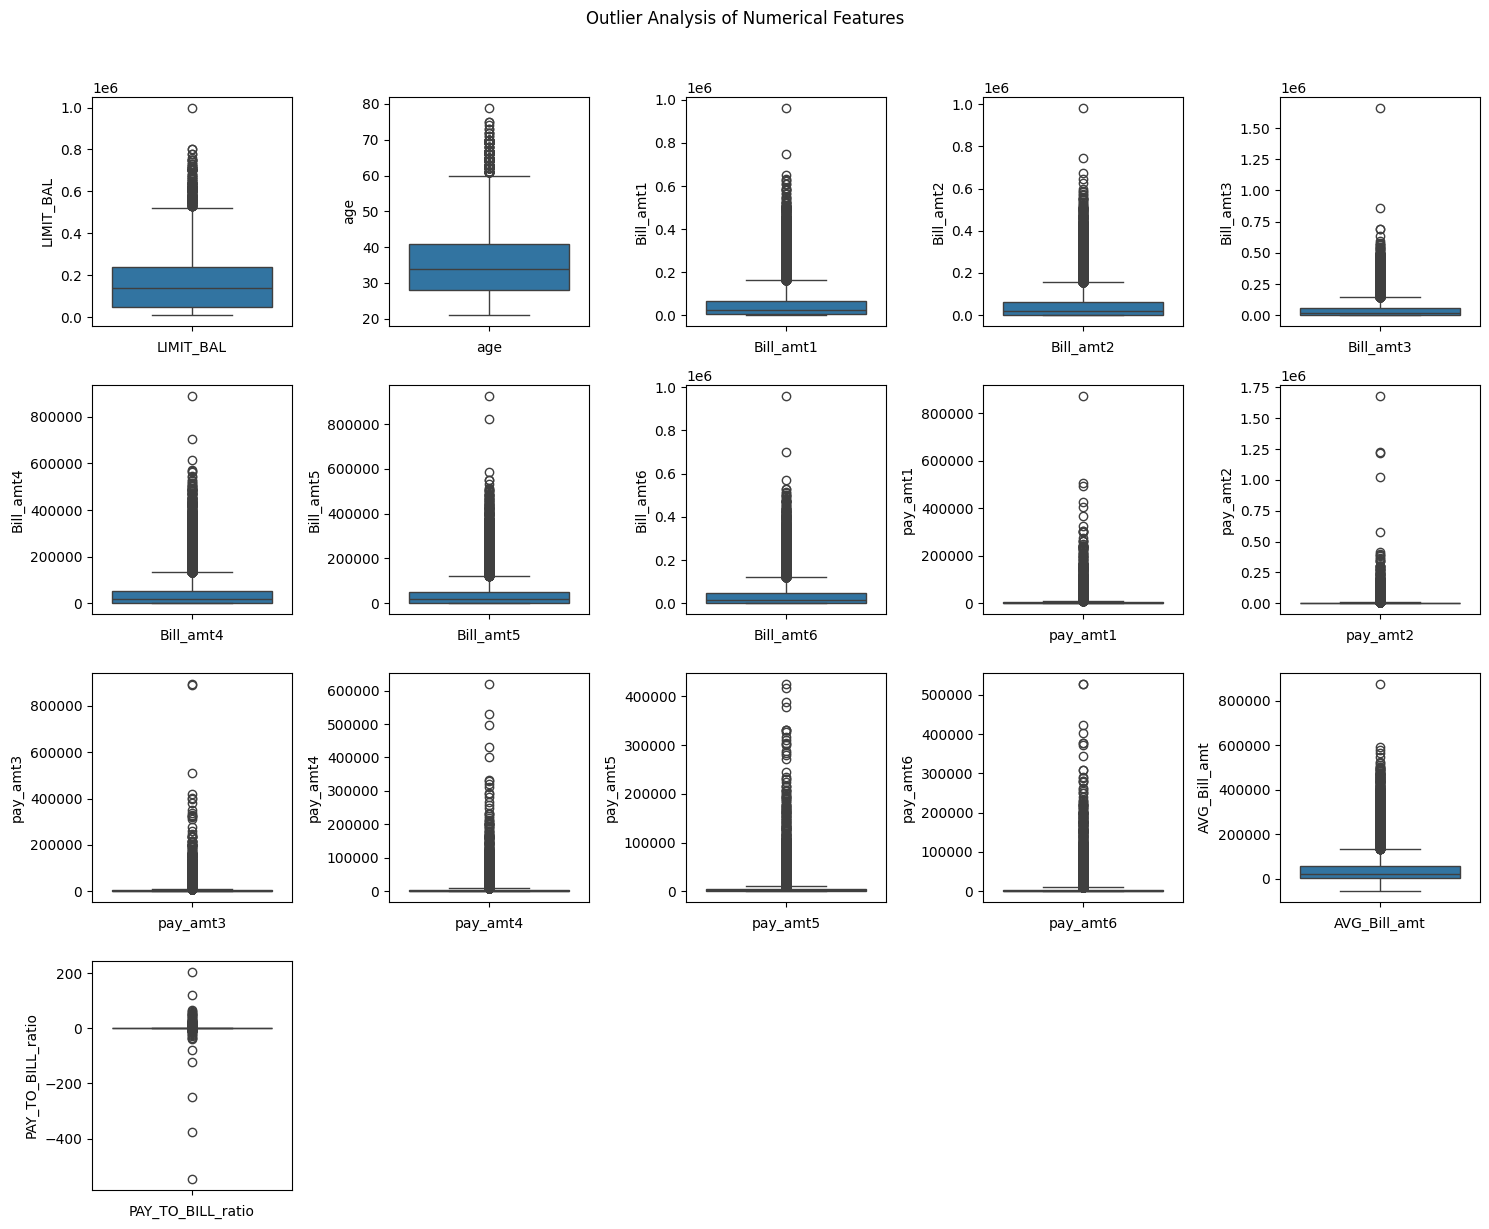

In [21]:
############################## Analysis of outliers
# figsize
plt.figure(figsize=(15,12))
# title
plt.suptitle('Outlier Analysis of Numerical Features', y=1.02)

for i,col in enumerate(numerical_features):
  plt.subplot(4, 5, i+1)

  # countplot
  sns.boxplot(df[col])
  # x-axis label
  plt.xlabel(col)
  plt.tight_layout()

In [22]:
############################# Clipping of Outliers
# we are going to replace the datapoints with upper and lower bound of all the outliers
def clip_outliers(df):
    for col in df[numerical_features]:
        # using IQR method to define range of upper and lower limit.
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # replacing the outliers with upper and lower bound
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

# using the function to treat outliers
df = clip_outliers(df)

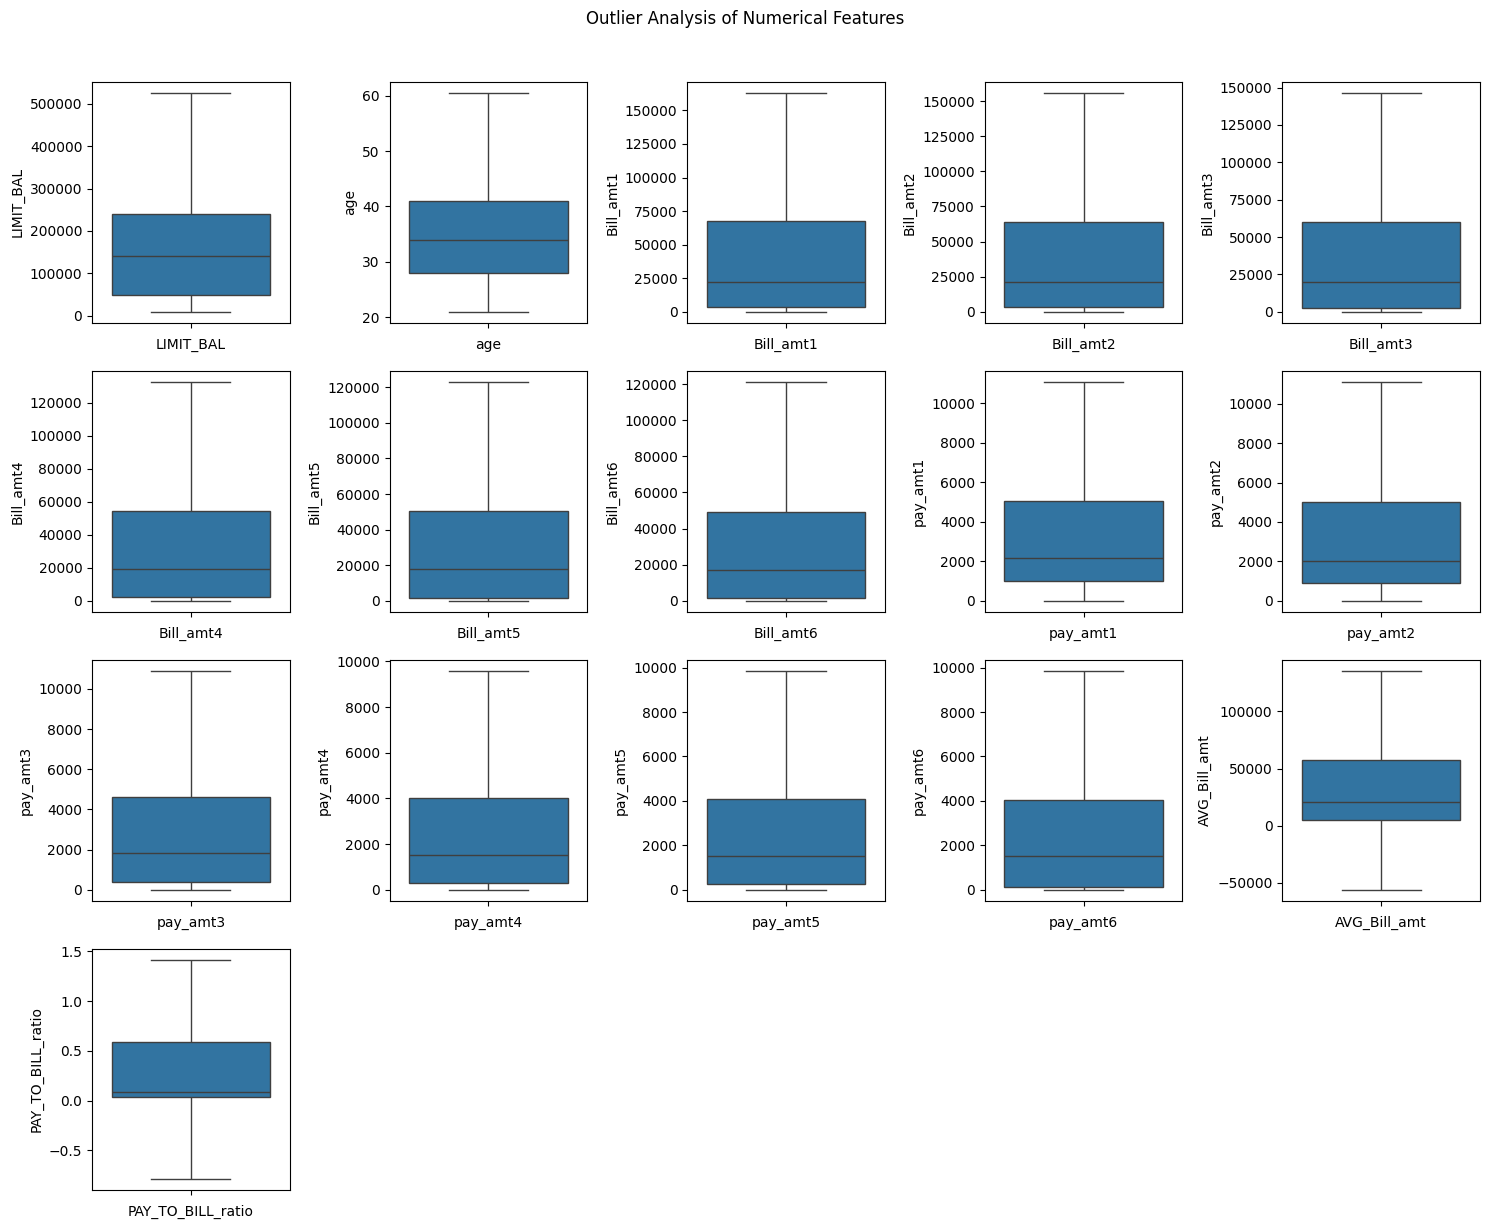

In [23]:
######################## Analysis of outliers after clipping
# figsize
plt.figure(figsize=(15,12))
# title
plt.suptitle('Outlier Analysis of Numerical Features', y=1.02)

for i,col in enumerate(numerical_features):
  plt.subplot(4, 5, i+1)

  # boxplot
  sns.boxplot(df[col])
  # x-axis label
  plt.xlabel(col)
  plt.tight_layout()

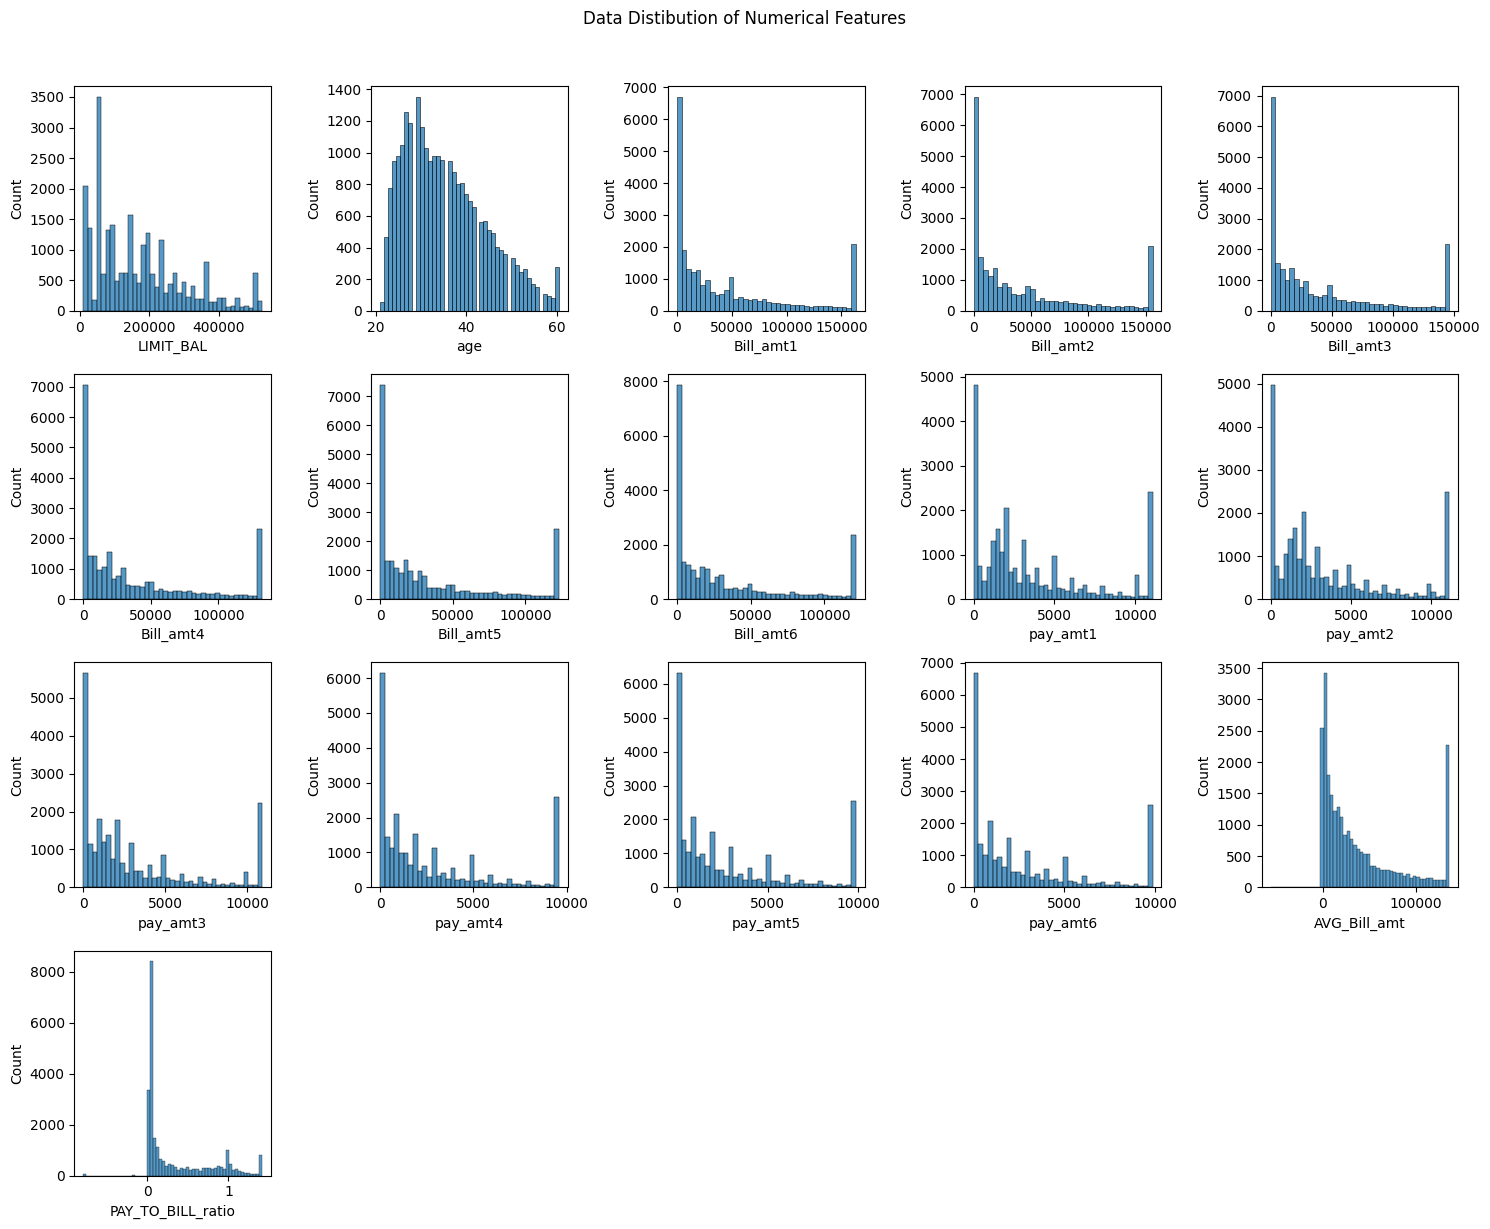

In [24]:
################### Analysis of numerical features after clipping

# figsize
plt.figure(figsize=(15,12))
# title
plt.suptitle('Data Distibution of Numerical Features', y=1.02)

for i,col in enumerate(numerical_features):
  plt.subplot(4, 5, i+1)

  # hist plots
  sns.histplot(df[col])
  # x-axis label
  plt.xlabel(col)
  plt.tight_layout()

In [25]:
df_train=df.copy()
# Checking the value counts of each sub-category of EDUCATION
df_train['education'].value_counts()

,count
education,
2,11717
1,8988
3,4115
5,253
4,116
6,44
0,14


In [26]:
df_train['marriage'].value_counts()

,count
marriage,
2,13441
1,11480
3,273
0,53


In [27]:
#################### Data cleaning

df_train = df_train[df_train['Bill_amt1'] >= 0]

#hadling nan values
df_train['age'].fillna(df_train['age'].median(), inplace=True)

#Remove duplicate rows
df_train =df_train.drop_duplicates()

# Replace all inconsistent values
df_train.loc[~df_train['education'].isin([1, 2, 3, 4]), 'education'] = 4

<ipython-input-27-3556930951>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['age'].fillna(df_train['age'].median(), inplace=True)


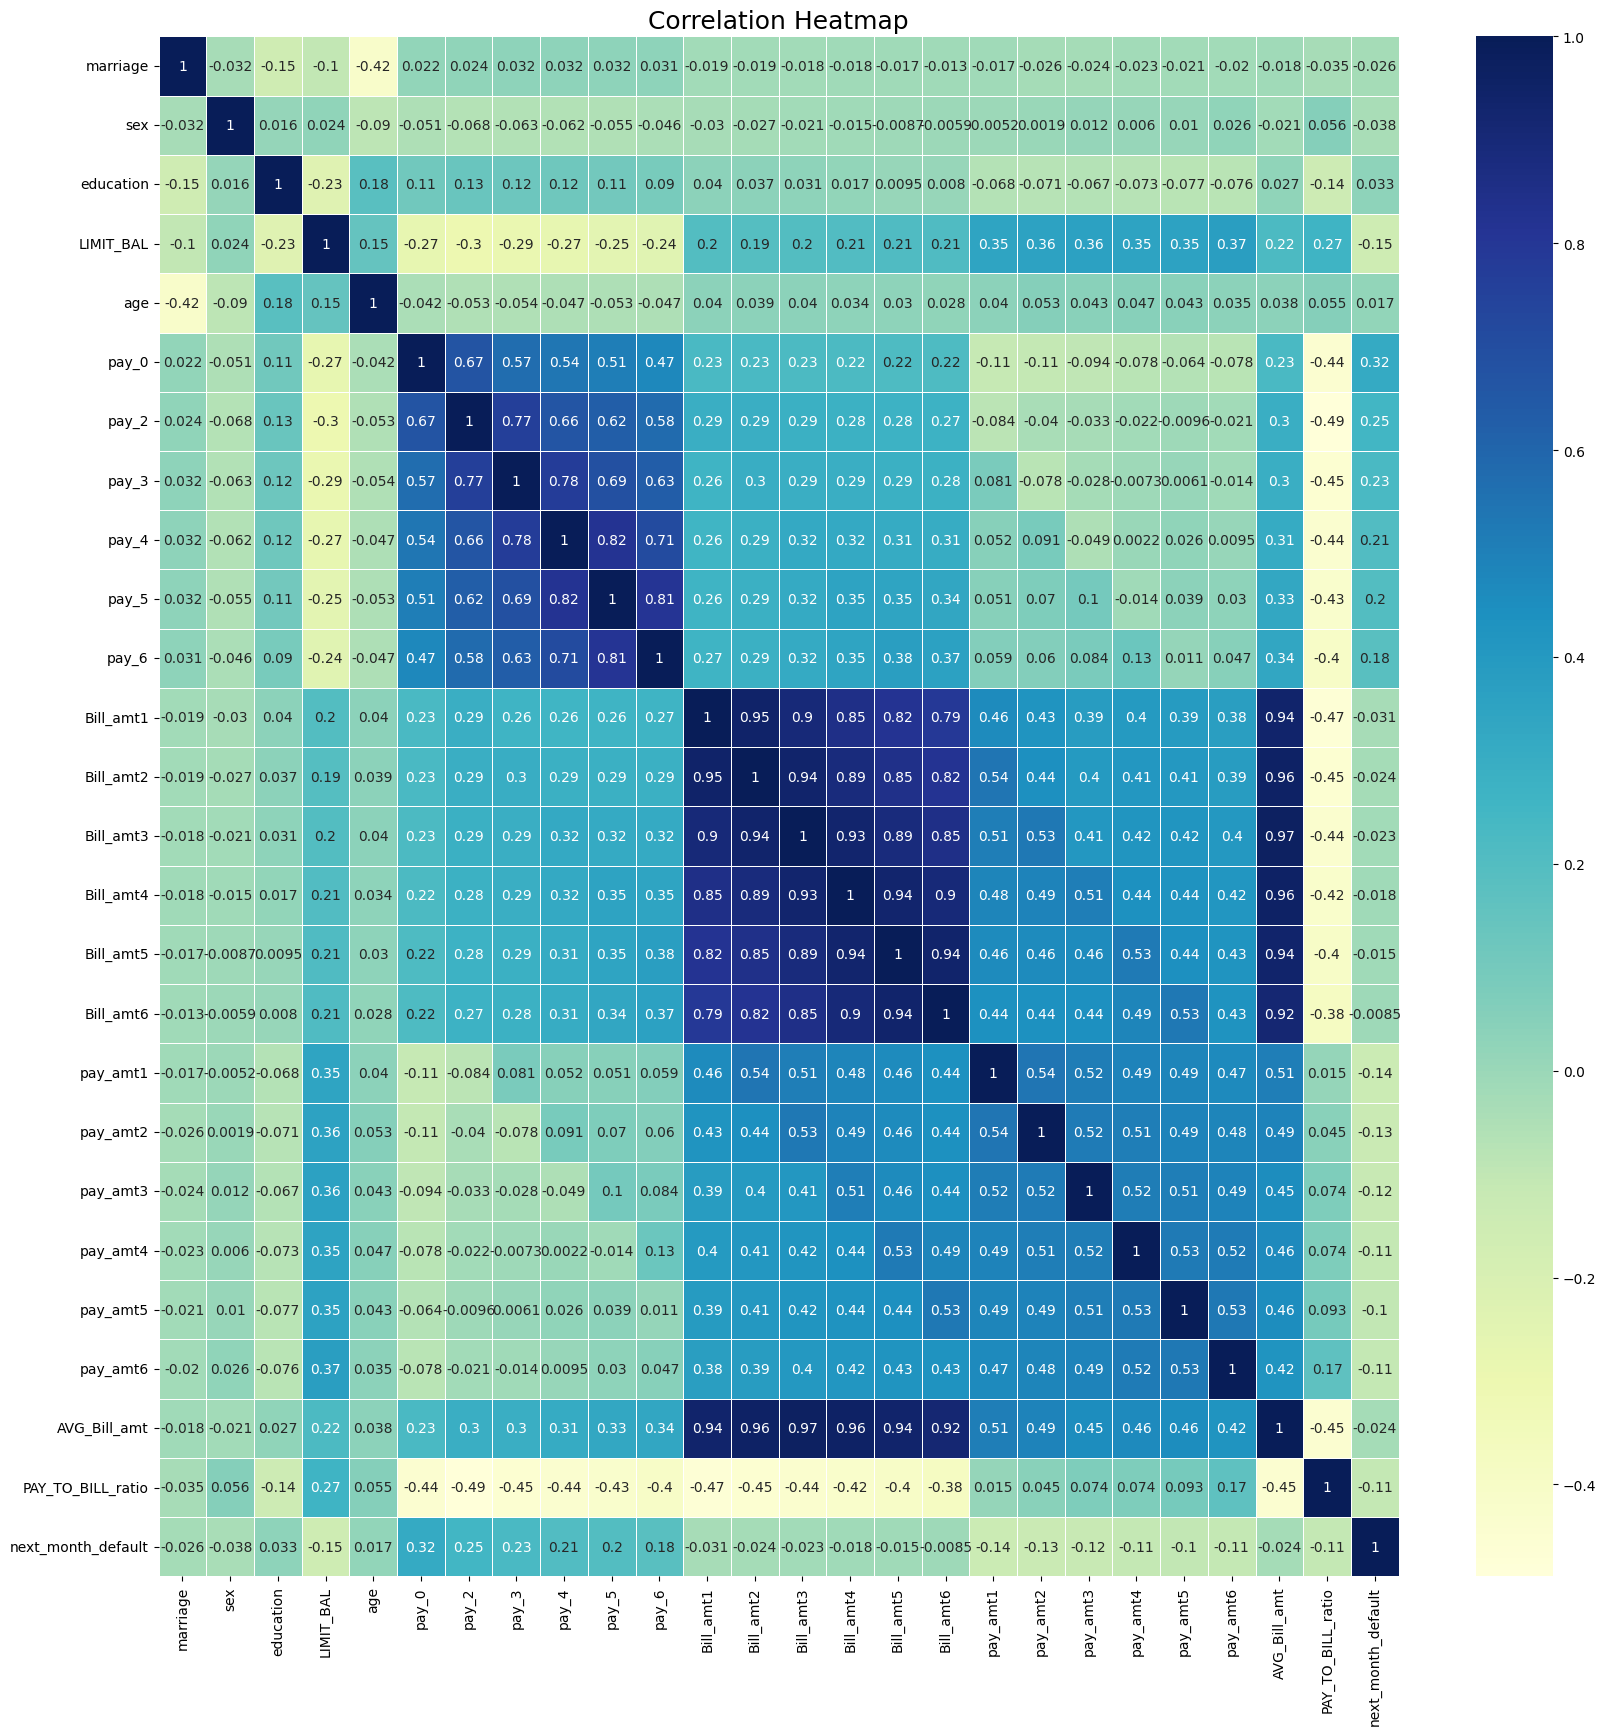

In [28]:
# Plotting correlation heatmap

plt.figure(figsize=(20, 20))
sns.heatmap(
    df_train.corr(),
    annot=True,
    cmap="YlGnBu",
    annot_kws={"size": 10},
    linewidths=0.5,
    linecolor='white'
)
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

# Feature engineering

In [29]:
############### find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

correlation(df_train, 0.7)

{'AVG_Bill_amt',
 'Bill_amt2',
 'Bill_amt3',
 'Bill_amt4',
 'Bill_amt5',
 'Bill_amt6',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6'}

In [30]:
########################################################### Datasheet tranformation ################################################################

################################################# Train Data #################################################

bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
pay_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

# 1. CV_bill (Coefficient of Variation of bill amounts)
df_train['CV_bill'] = df_train[bill_cols].std(axis=1) / df_train[bill_cols].mean(axis=1)

# 2. CV_pay (Coefficient of Variation of payment amounts)
df_train['CV_pay'] = df_train[pay_cols].std(axis=1) / df_train[pay_cols].mean(axis=1)

# 3. Frequency of zero payments
df_train['zero_payment_freq'] = (df_train[pay_cols] == 0).sum(axis=1)

# 4. Payment status variables(average payment status and maximum payment status)
df_train['avg_payment_status'] = df_train[pay_status_cols].mean(axis=1)
df_train['max_payment_status'] = df_train[pay_status_cols].max(axis=1)

# 5. Credit utilization ratio
df_train['credit_util_ratio'] = df_train['AVG_Bill_amt'] / df_train['LIMIT_BAL']

# 6. Total bill – total payment
df_train['total_bill'] = df_train[bill_cols].sum(axis=1)
df_train['total_payment'] = df_train[pay_cols].sum(axis=1)
df_train['bill_minus_payment'] = df_train['total_bill'] - df_train['total_payment']

# Drop temporary total columns
df_train.drop(columns=['total_bill', 'total_payment',], inplace=True)

# 7. Repayment consistency: CV of monthly pay-to-bill ratios
ratios = df_train[pay_cols].values / (df_train[bill_cols].replace(0, np.nan).values)
df_train['repayment_cv'] = pd.DataFrame(ratios).std(axis=1) / pd.DataFrame(ratios).mean(axis=1)


################################################### Validate Dataset ##########################################################

df_predict=df_validate.copy()

# 1. CV_bill (Coefficient of Variation of bill amounts)
df_predict['CV_bill'] = df_predict[bill_cols].std(axis=1) / df_predict[bill_cols].mean(axis=1)

# 2. CV_pay (Coefficient of Variation of payment amounts)
df_predict['CV_pay'] = df_predict[pay_cols].std(axis=1) /df_predict[pay_cols].mean(axis=1)

# 3. Frequency of zero payments
df_predict['zero_payment_freq'] = (df_predict[pay_cols] == 0).sum(axis=1)

# 4. Payment status variables (average payment status and maximum payment status)
df_predict['avg_payment_status'] = df_predict[pay_status_cols].mean(axis=1)
df_predict['max_payment_status'] = df_predict[pay_status_cols].max(axis=1)

# 5. Credit utilization ratio
df_predict['credit_util_ratio'] = df_predict['AVG_Bill_amt'] /df_predict['LIMIT_BAL']

# 6. Total bill – total payment
df_predict['total_bill'] = df_predict[bill_cols].sum(axis=1)
df_predict['total_payment'] = df_predict[pay_cols].sum(axis=1)
df_predict['bill_minus_payment'] = df_predict['total_bill'] - df_predict['total_payment']

# Drop temporary total columns if not needed
df_predict.drop(columns=['total_bill', 'total_payment',], inplace=True)

# 7. Repayment consistency: CV of monthly pay-to-bill ratios
ratios = df_predict[pay_cols].values / (df_predict[bill_cols].replace(0, np.nan).values)
df_predict['repayment_cv'] = pd.DataFrame(ratios).std(axis=1) / pd.DataFrame(ratios).mean(axis=1)

df_predict.drop('Customer_ID',axis=1,inplace=True)
df_train.head()

,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,PAY_TO_BILL_ratio,next_month_default,CV_bill,CV_pay,zero_payment_freq,avg_payment_status,max_payment_status,credit_util_ratio,bill_minus_payment,repayment_cv
0,2,0,2,60000,25.0,2,2,2,0,0,...,0.03,0,0.471809,0.539108,1,1.000000,2,0.691858,241111.880,0.689979
1,2,1,1,290000,24.0,0,0,-2,-2,-1,...,0.27,0,1.719909,1.673298,3,-0.833333,0,0.008740,11160.470,2.235396
2,1,0,2,180000,60.5,0,0,0,0,0,...,0.04,0,0.037111,0.061676,0,0.000000,0,0.280122,290474.380,0.087501
3,1,1,2,210000,43.0,0,0,0,0,0,...,0.04,0,0.075042,0.109803,0,0.000000,0,0.410617,498929.030,0.067299
4,2,0,1,280000,32.0,-2,-2,-2,-2,-2,...,0.72,0,1.506463,1.440727,0,-2.000000,-2,0.042194,53697.485,1.451667


In [31]:
df_train['CV_bill'] = df_train['CV_bill'].fillna(0)
df_train['CV_pay'] = df_train['CV_pay'].fillna(0)
df_train['repayment_cv'] = df_train['repayment_cv'].fillna(0)

df_predict['CV_bill'] = df_predict['CV_bill'].fillna(0)
df_predict['CV_pay'] = df_predict['CV_pay'].fillna(0)
df_predict['repayment_cv'] = df_predict['repayment_cv'].fillna(0)

df_train = df_train.replace([np.inf, -np.inf], np.nan).fillna(0)
df_predict = df_predict.replace([np.inf, -np.inf], np.nan).fillna(0)

In [32]:
print(df_train.columns)

Index(['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2',
       'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default', 'CV_bill',
       'CV_pay', 'zero_payment_freq', 'avg_payment_status',
       'max_payment_status', 'credit_util_ratio', 'bill_minus_payment',
       'repayment_cv'],
      dtype='object')


In [33]:
print(df_predict.columns)

Index(['marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2',
       'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'CV_bill', 'CV_pay',
       'zero_payment_freq', 'avg_payment_status', 'max_payment_status',
       'credit_util_ratio', 'bill_minus_payment', 'repayment_cv'],
      dtype='object')


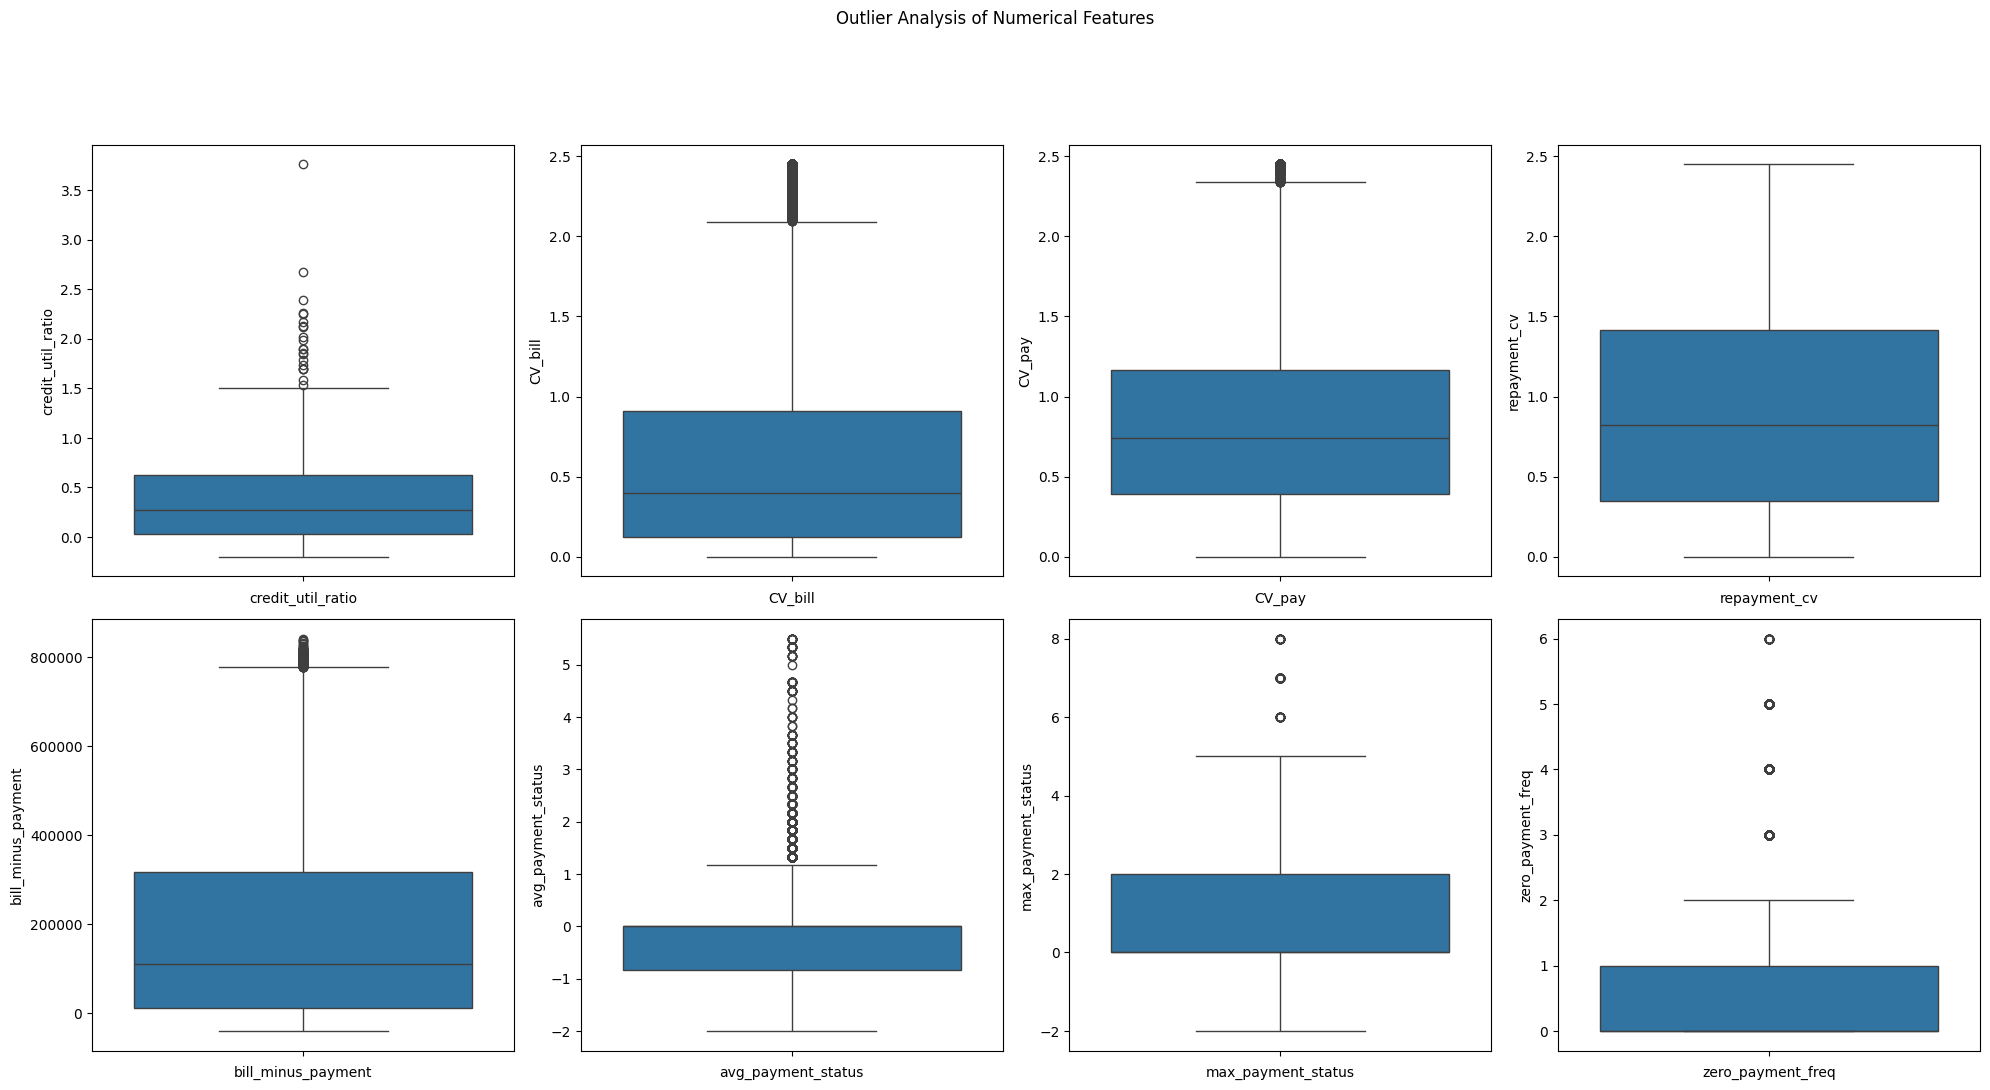

In [34]:
################## Engineered feature distributions by class

eng_features = ['credit_util_ratio','CV_bill', 'CV_pay', 'repayment_cv','bill_minus_payment','avg_payment_status','max_payment_status','zero_payment_freq']

plt.figure(figsize=(20, 15))
plt.suptitle('Outlier Analysis of Numerical Features', y=1.02)

for i, col in enumerate(eng_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(df_train[col])
    plt.xlabel(col)

plt.tight_layout()
plt.subplots_adjust(top=0.93)




In [35]:
############################# Clipping of Outliers on engineering features
# we are going to replace the datapoints with upper and lower bound of all the outliers
def clip_outliers(df):
    for col in df[eng_features]:
        # using IQR method to define range of upper and lower limit.
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # replacing the outliers with upper and lower bound
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

# using the function to treat outliers
df_train = clip_outliers(df_train)

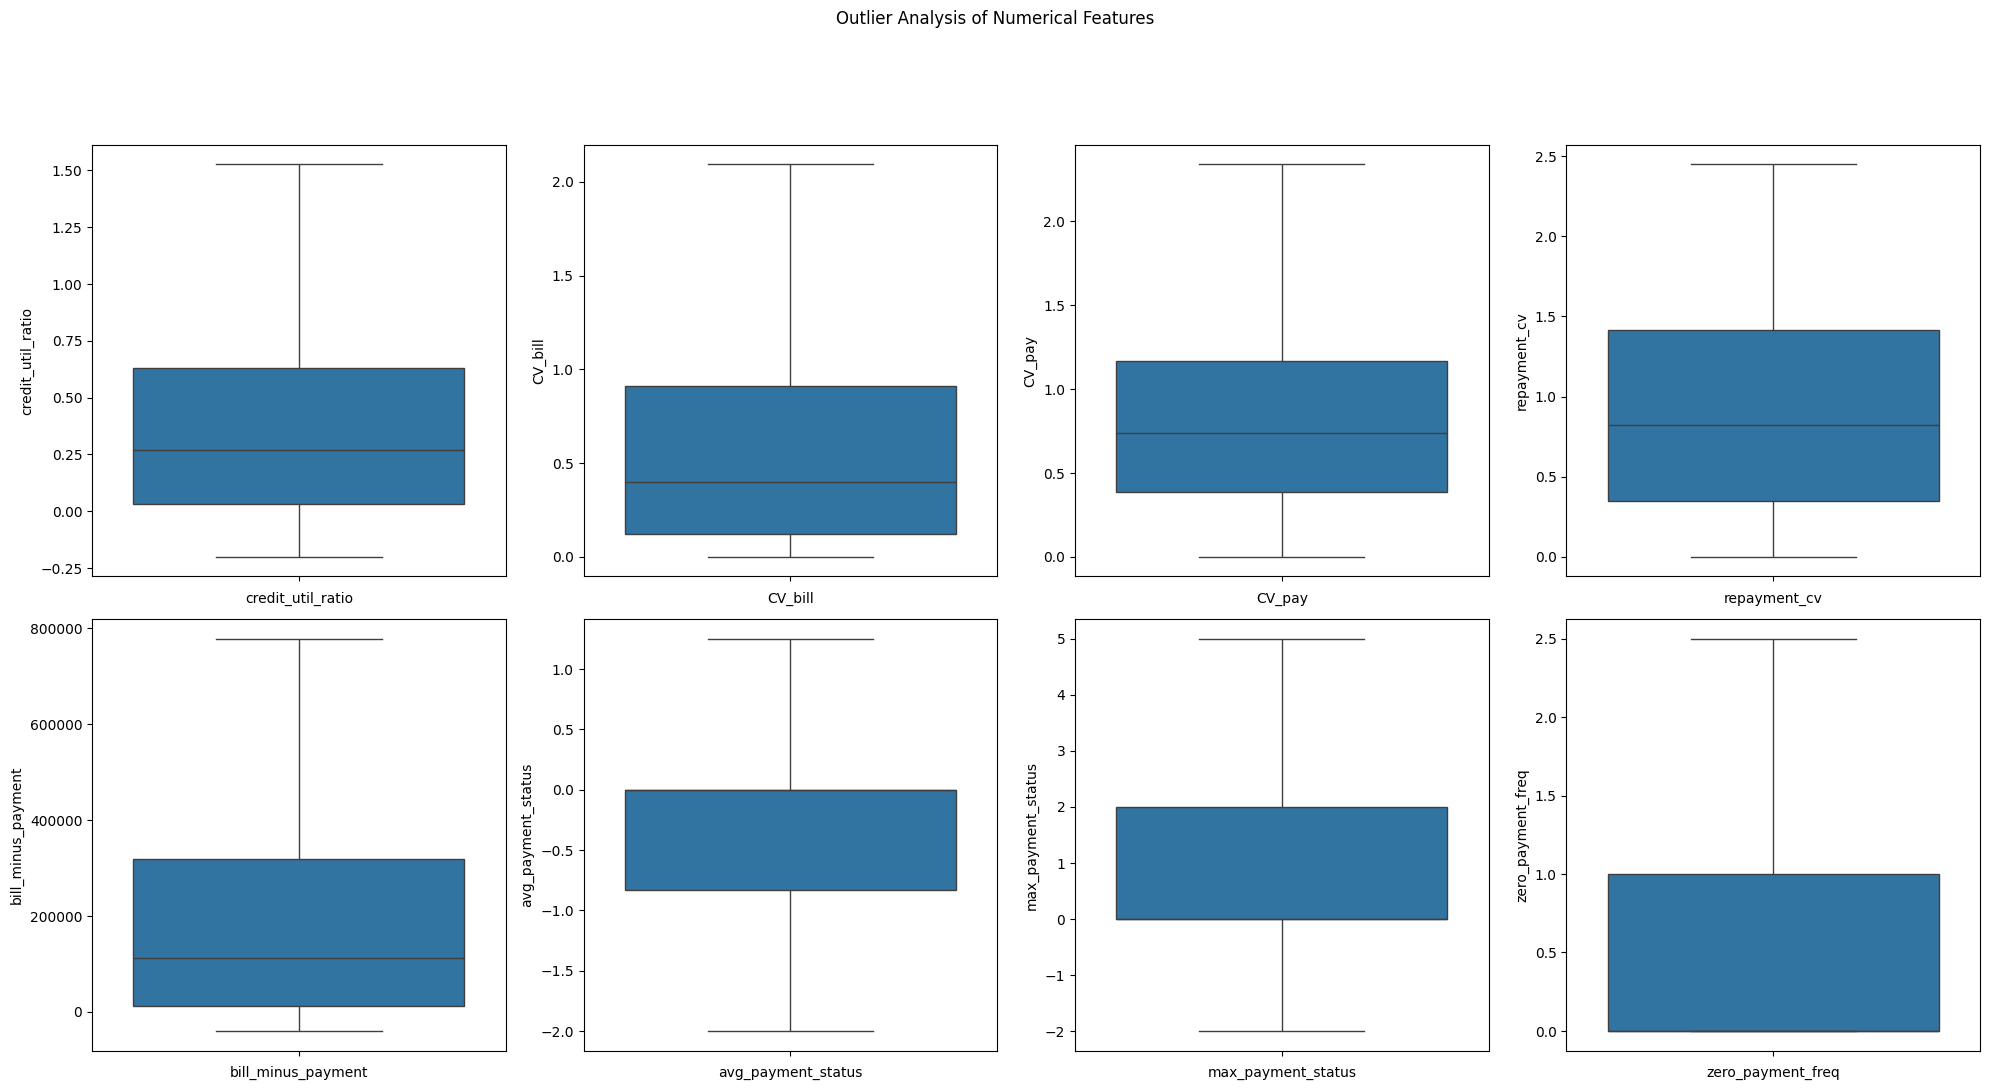

In [36]:
###################### Analysis of engineering features after clipping
plt.figure(figsize=(20, 15))
plt.suptitle('Outlier Analysis of Numerical Features', y=1.02)

for i, col in enumerate(eng_features):
    plt.subplot(3, 4, i+1)  # 3 rows × 4 columns = 12 plots
    sns.boxplot(df_train[col])
    plt.xlabel(col)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust to avoid overlap with suptitle

In [37]:
print(df_train.describe())

           marriage           sex     education      LIMIT_BAL           age  \
count  24441.000000  24441.000000  24441.000000   24441.000000  24441.000000   
mean       1.551205      0.603862      1.840882  167766.948979     35.403748   
std        0.522731      0.489104      0.749364  128094.504122      9.051609   
min        0.000000      0.000000      1.000000   10000.000000     21.000000   
25%        1.000000      0.000000      1.000000   50000.000000     28.000000   
50%        2.000000      1.000000      2.000000  140000.000000     34.000000   
75%        2.000000      1.000000      2.000000  240000.000000     41.000000   
max        3.000000      1.000000      4.000000  525000.000000     60.500000   

              pay_0         pay_2         pay_3         pay_4         pay_5  \
count  24441.000000  24441.000000  24441.000000  24441.000000  24441.000000   
mean      -0.037560     -0.154372     -0.184853     -0.236979     -0.278712   
std        1.104661      1.179520      1.1

# Smote

In [38]:
X=df_train.drop(['next_month_default'],axis=1)
y=df_train['next_month_default']

In [39]:
# Resampling the minority class
smote = SMOTE(random_state=42)

# fit predictor and target variable
X_res, y_res = smote.fit_resample(X, y)

print(f'After Handling Imbalanced class {Counter(y)}')

After Handling Imbalanced class Counter({0: 19634, 1: 4807})


In [40]:
# Split dataset into train_val and test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(31414, 33)
(7854, 33)


In [41]:
cat_cols = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# XGB Classifier

In [42]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    enable_categorical=True,
    random_state=42
)

xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:02:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [43]:
# Predict labels
y_pred = xgb_model.predict(X_test)

# Predict probabilities
y_probs = xgb_model.predict_proba(X_test)[:, 1]

Evaluation Metrics:
Accuracy:  0.8900
ROC AUC:   0.9468
F1 Score:  0.8837
F2 Score:  0.8599

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      3970
           1       0.93      0.84      0.88      3884

    accuracy                           0.89      7854
   macro avg       0.89      0.89      0.89      7854
weighted avg       0.89      0.89      0.89      7854



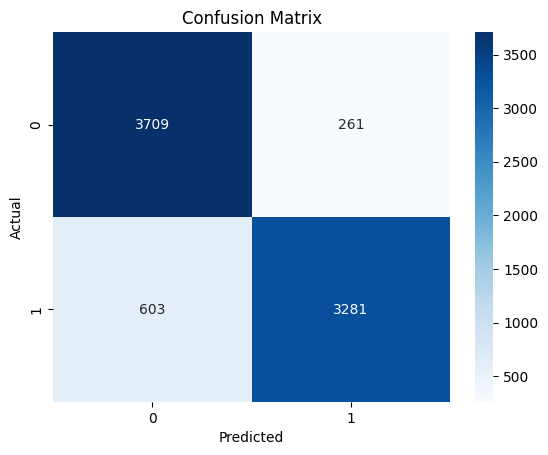

In [44]:
################### evaluation metrics
# Accuracy
acc = accuracy_score(y_test, y_pred)

# ROC-AUC
roc = roc_auc_score(y_test, y_probs)

# F1 Score (β = 1)
f1 = f1_score(y_test, y_pred)

# F2 Score (β = 2)
f2 = fbeta_score(y_test, y_pred, beta=2)

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"F2 Score:  {f2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


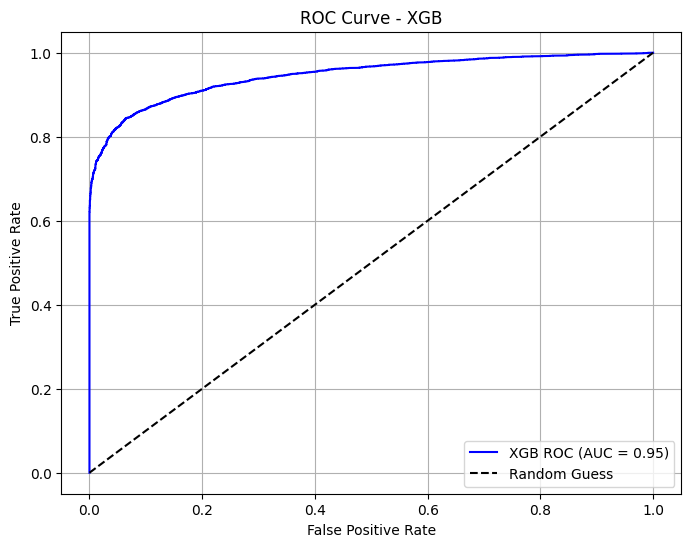

In [45]:
################# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test,y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGB ROC (AUC = {:.2f})'.format(auc), color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB')
plt.legend()
plt.grid()
plt.show()

In [46]:
y_probs  = xgb_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

best_f2 = 0
best_thresh = 0.5
for t in thresholds:
    preds = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print("Best F2 Score:", best_f2)
print("Best Threshold:", best_thresh)

Best F2 Score: 0.8949540608264138
Best Threshold: 0.19799998


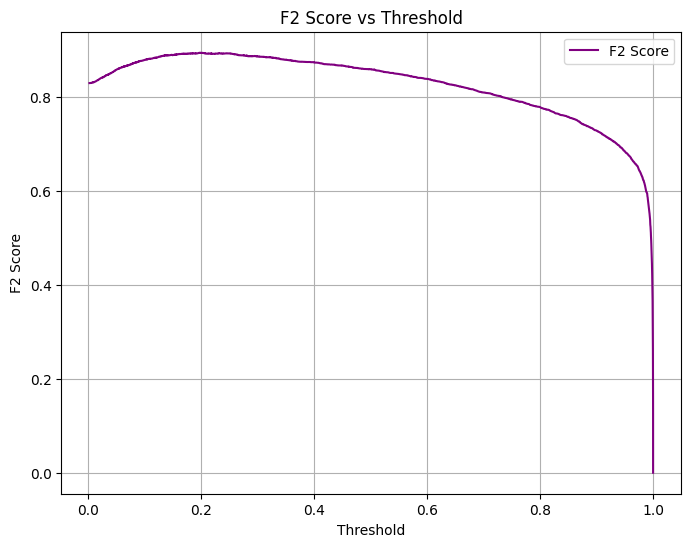

In [47]:
f2_scores = [fbeta_score(y_test, (y_probs >= t).astype(int), beta=2) for t in thresholds]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f2_scores, label="F2 Score", color='purple')
plt.xlabel("Threshold")
plt.ylabel("F2 Score")
plt.title("F2 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()


Evaluation Metrics:
Accuracy:  0.8198
ROC AUC:   0.9468
F1 Score:  0.8374
F2 Score:  0.8950

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      3970
           1       0.76      0.94      0.84      3884

    accuracy                           0.82      7854
   macro avg       0.84      0.82      0.82      7854
weighted avg       0.84      0.82      0.82      7854



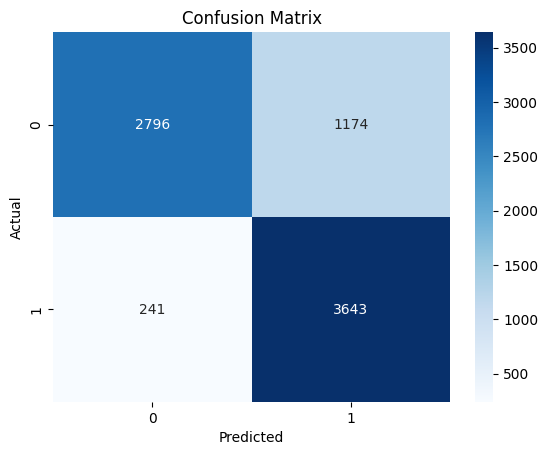

In [48]:
# Use best threshold to generate final predicted labels
final_preds = (y_probs>= best_thresh).astype(int)

# Accuracy
acc = accuracy_score(y_test, final_preds)

# ROC-AUC
roc = roc_auc_score(y_test, y_probs )

# F1 Score (β = 1)
f1 = f1_score(y_test, final_preds)

# F2 Score (β = 2)
f2 = fbeta_score(y_test, final_preds, beta=2)

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"F2 Score:  {f2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_preds))

cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [50]:
# Predict probabilities on validation data
y_predict_probs = xgb_model.predict_proba(df_predict)[:, 1]

# Apply optimal threshold from earlier
y_predict_final = (y_predict_probs >= best_thresh).astype(int)

# Attach results to Customer_IDs
df_output = df_validate[['Customer_ID']].copy()
df_output['predicted_default'] = y_predict_final


# View sample
print(df_output.head())



   Customer_ID  predicted_default
0            1                  0
1            2                  1
2            3                  0
3            4                  1
4            5                  0


In [51]:
df_output['predicted_default'].value_counts()

,count
predicted_default,
1,3184
0,1832


In [52]:
# save to CSV
df_output.to_csv('/content/gdrive/My Drive/CreditCardDefault/validation_predictions.csv', index=False)

#Descision Tree Classifier


In [53]:
dtc_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtc_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [54]:
# Predict labels
y_pred = dtc_model.predict(X_test)

# Predict probabilities
y_probs = dtc_model.predict_proba(X_test)[:, 1]

Evaluation Metrics:
Accuracy:  0.8172
ROC AUC:   0.8173
F1 Score:  0.8181
F2 Score:  0.8262

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3970
           1       0.81      0.83      0.82      3884

    accuracy                           0.82      7854
   macro avg       0.82      0.82      0.82      7854
weighted avg       0.82      0.82      0.82      7854



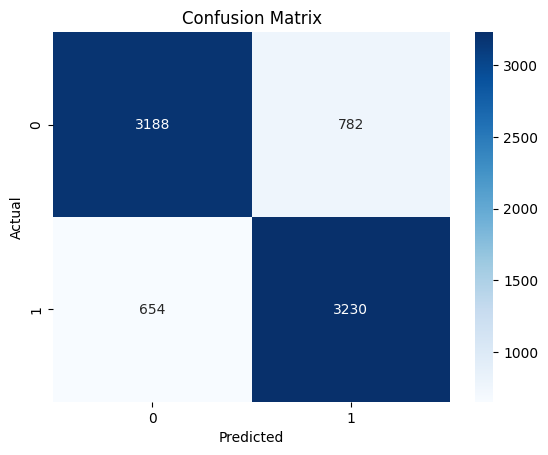

In [55]:
# Accuracy
acc = accuracy_score(y_test, y_pred)

# ROC-AUC
roc = roc_auc_score(y_test, y_probs)

# F1 Score (β = 1)
f1 = f1_score(y_test, y_pred)

# F2 Score (β = 2)
f2 = fbeta_score(y_test, y_pred, beta=2)

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"F2 Score:  {f2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [56]:
y_probs = dtc_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

best_f2 = 0
best_thresh = 0.5

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print("Best threshold for Decision Tree:", best_thresh)
print("Best F2 score:", best_f2)


Best threshold for Decision Tree: 0.0
Best F2 score: 0.8302693458743052


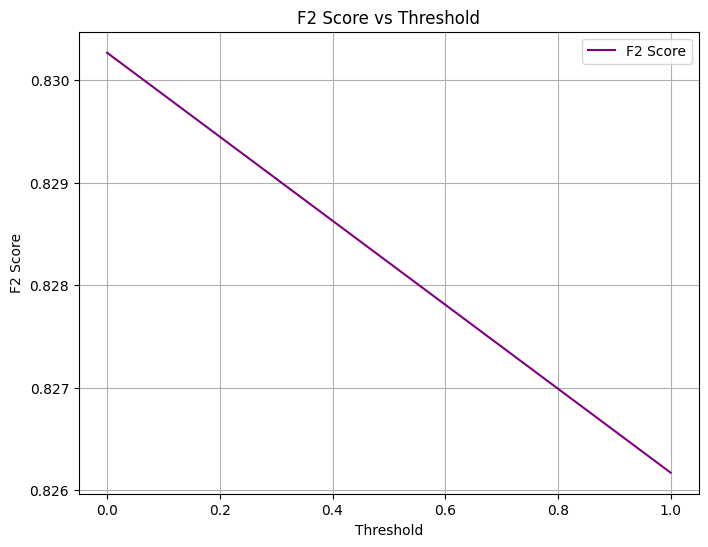

In [57]:
f2_scores = [fbeta_score(y_test, (y_probs >= t).astype(int), beta=2) for t in thresholds]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f2_scores, label="F2 Score", color='purple')
plt.xlabel("Threshold")
plt.ylabel("F2 Score")
plt.title("F2 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

In [58]:
# Predict probabilities on validation data
y_predict_probs = dtc_model.predict_proba(df_predict)[:, 1]

# Apply optimal threshold from earlier
y_predict_final = (y_predict_probs >= best_thresh).astype(int)

# Attach results to Customer_IDs
df_output = df_validate[['Customer_ID']].copy()
df_output['predicted_default'] = y_predict_final


# View sample
print(df_output.head())

   Customer_ID  predicted_default
0            1                  1
1            2                  1
2            3                  1
3            4                  1
4            5                  1


In [59]:
df_output['predicted_default'].value_counts()

,count
predicted_default,
1,5016


#Logistic Regression

In [60]:
# Scaling Data
###Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Evaluation Metrics
Accuracy Score     : 0.7475
ROC AUC Score      : 0.8192
F1 Score           : 0.7463
F2 Score (β=2)     : 0.7491

 Classification Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      3970
           1       0.74      0.75      0.75      3884

    accuracy                           0.75      7854
   macro avg       0.75      0.75      0.75      7854
weighted avg       0.75      0.75      0.75      7854



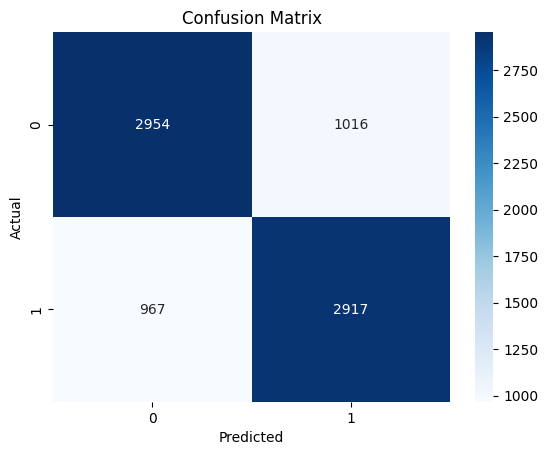

In [61]:
# Train a model
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # balanced to handle imbalance
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)

# Output results
print(" Evaluation Metrics")
print(f"Accuracy Score     : {accuracy:.4f}")
print(f"ROC AUC Score      : {roc_auc:.4f}")
print(f"F1 Score           : {f1:.4f}")
print(f"F2 Score (β=2)     : {f2:.4f}")
print("\n Classification Report")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [62]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

best_f2 = 0
best_thresh = 0.5

for t in thresholds:
    preds = (y_probs >= t).astype(int)
    f2 = fbeta_score(y_test, preds, beta=2)
    if f2 > best_f2:
        best_f2 = f2
        best_thresh = t

print("Best threshold for Logistic Regression:", best_thresh)
print("Best F2 score:", best_f2)


Best threshold for Logistic Regression: 0.2130619132325307
Best F2 score: 0.8453711274643408


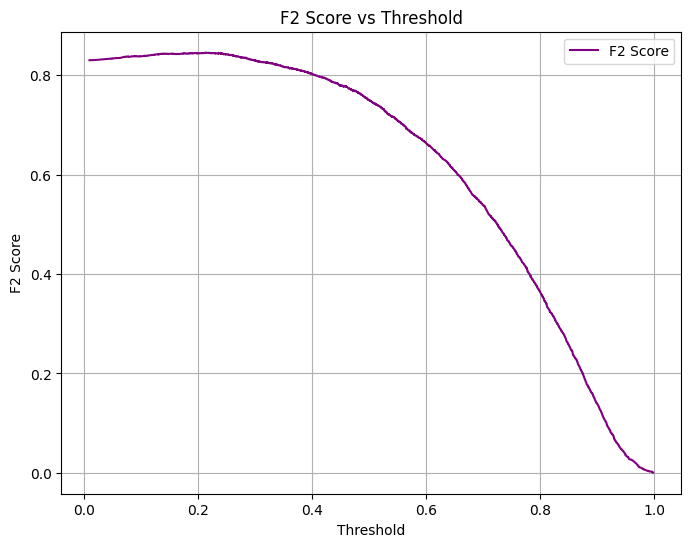

In [63]:
f2_scores = [fbeta_score(y_test, (y_probs >= t).astype(int), beta=2) for t in thresholds]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f2_scores, label="F2 Score", color='purple')
plt.xlabel("Threshold")
plt.ylabel("F2 Score")
plt.title("F2 Score vs Threshold")
plt.grid(True)
plt.legend()
plt.show()

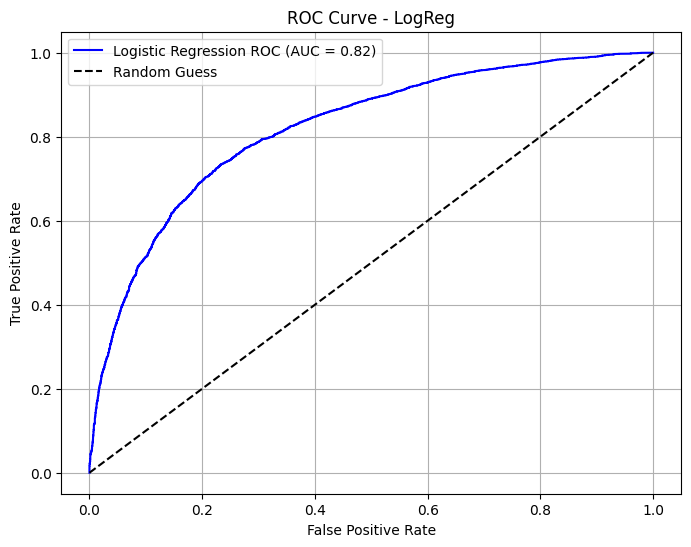

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test,y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression ROC (AUC = {:.2f})'.format(auc), color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LogReg')
plt.legend()
plt.grid()
plt.show()

Evaluation Metrics:
Accuracy:  0.6285
ROC AUC:   0.8192
F1 Score:  0.7184
F2 Score:  0.8454

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.31      0.45      3970
           1       0.57      0.96      0.72      3884

    accuracy                           0.63      7854
   macro avg       0.73      0.63      0.59      7854
weighted avg       0.73      0.63      0.58      7854



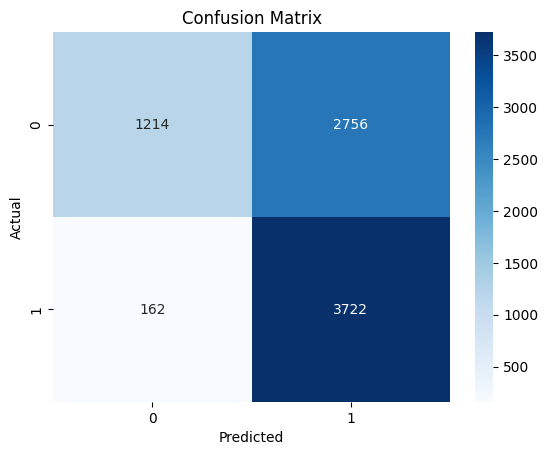

In [65]:
# Use best threshold to generate final predicted labels
final_preds = (y_probs>= best_thresh).astype(int)

# Accuracy
acc = accuracy_score(y_test, final_preds)

# ROC-AUC
roc = roc_auc_score(y_test, y_probs )

# F1 Score (β = 1)
f1 = f1_score(y_test, final_preds)

# F2 Score (β = 2)
f2 = fbeta_score(y_test, final_preds, beta=2)

print("Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"ROC AUC:   {roc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"F2 Score:  {f2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_preds))

cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [66]:
# Predict probabilities on validation data
y_predict_probs = model.predict_proba(df_predict)[:, 1]

# Apply optimal threshold from earlier
y_predict_final = (y_predict_probs >= best_thresh).astype(int)

# Attach results to Customer_IDs
df_output = df_validate[['Customer_ID']].copy()
df_output['predicted_default'] = y_predict_final


# View sample
print(df_output.head())


   Customer_ID  predicted_default
0            1                  0
1            2                  1
2            3                  0
3            4                  0
4            5                  0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [67]:
df_output['predicted_default'].value_counts()

,count
predicted_default,
0,4727
1,289
